# Goal:

In this assignment, you will implement the self-supervised contrastive learning algorithm, [SimCLR](https://arxiv.org/abs/2002.05709), using PyTorch. You will use the STL-10 dataset for this assignment.

You need to compete the `Net` class definition, the `SimCLRDataset` dataset class definition and the SimCLR loss in the `Trainer` class. You need to run the training loop, save the best training model and evaluate using the `linear probe` classfication task. Since we don't have enough GPU resources and contrastive learning algorithm like SimCLR usually needs around `1000` epoches to train (we only have `70` epoches), you may not get the best performance. Thus, as for the performance side, as long as you see the loss is decreasing (to around 7.4 at `70` epoch) and the accuracy is increasing, you are good to go.

Grade:

- **Fill the Net class definition (5 points).**
- **Fill the SimCLRDataset dataset class definition (10 points).**
- **Fill the SimCLR loss in the Trainer class (20 points).**
- **Record the training loss within 70 epochs, the lower the better (5 points).**
- **Record the linear probe accuracy, the higher the better (5 points).**
- **Write a report including:**
  - **How you select data augmentation (transform) in the transform pool.**
  - **How you implement the SimCLR loss and explain why your SimCLR loss is computationally efficient and equivalent to the loss function in the paper.**
  - **Include the training loss curve and the downstream accuracy (15 points). Note that the logging logic is not provided, please implement them before you start training.**
---
Please DO NOT change the config provided. Only change the given code if you are confident that the change is necessary. It is recommended that you **use CPU session to debug** when GPU is not necessary since Colab only gives 12 hrs of free GPU access at a time. If you use up the GPU resource, you may consider to use Kaggle GPU resource. Thank you and good luck!

# Self-supervised learning: SimCLR

Self-supervised learning

1.   Design an auxiliary task.
2.   Train the base network on the auxiliary task.
3.   Evaluate on the down-stream task: Train a new decoder based on the trained encoder.

Specifically, as one of the most successful self-supervised learning algorithm, SimCLR, a contrastive learning algorithm is what we focus today. Below, we are going to implement SimCLR as an example of self-supervised learning.


<img src="https://camo.githubusercontent.com/35af3432fbe91c56a934b5ee58931b4848ab35043830c9dd6f08fa41e6eadbe7/68747470733a2f2f312e62702e626c6f6773706f742e636f6d2f2d2d764834504b704539596f2f586f3461324259657276492f414141414141414146704d2f766146447750584f79416f6b4143385868383532447a4f67457332324e68625877434c63424741735948512f73313630302f696d616765342e676966" width="650" height="650">

In [ ]:
# Config
# Since, we are using jupyter notebook, we use easydict to micic argparse. Feel free to use other format of config
from easydict import EasyDict
import torch.nn as nn
from tqdm import tqdm
import torch

config = {
    'dataset_name': 'stl10',
    'workers': 2,
    'epochs': 70,
    'batch_size': 3072,
    'lr': 0.0003,
    'weight_decay': 1e-4,
    'seed': 4242,
    'fp16_precision': True,
    'out_dim': 128,
    'temperature': 0.5,
    'n_views': 2,
    'device': "cuda" if torch.cuda.is_available() else "cpu",
}

args = EasyDict(config)

We are going to use [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/).

<img src="https://cs.stanford.edu/~acoates/stl10/images.png" width="450" height="450">

Overview

*   10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
*   Images are **96x96** pixels, color.
*   500 training images (10 pre-defined folds), 800 test images per class.
*   100000 unlabeled images for unsupervised learning. These examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.
*   Images were acquired from labeled examples on ImageNet.


## Preparation

Define a ResNet-18 and an additional MLP layer as the model training in the auxiliary task.

In [ ]:
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.basemodel = models.resnet18(pretrained=False, num_classes=args.out_dim)
        self.fc_in_features = self.basemodel.fc.in_features
        self.backup_fc = self.basemodel.fc  # Backup the last Linear layer of the basemodel
        # ToDO: define an MLP layer to insert between the last layer and the rest of the model
        self.mlp = nn.Sequential(nn.Linear(self.fc_in_features,self.fc_in_features), nn.ReLU(), self.basemodel.fc)
        # redefine the last fc layer to the new mlp layer block defined above
        self.basemodel.fc = self.mlp

    def forward(self, x):
        # ToDo: implement the forward logic
        x = self.basemodel(x)
        return x

    def linear_probe(self):
        self.freeze_basemodel_encoder()
        self.backup_fc = self.basemodel.fc  # Backup the last Linear layer

        # ToDo: implement the linear probe for your downstream task. A linear prob is just a linear layer (not MLP, no activation layer included) after the learned encoder.
        self.basemodel.fc = nn.Linear(self.fc_in_features, 10)

    def restore_backbone(self):
        self.basemodel.fc = self.backup_fc
        self.backup_fc = None

    def freeze_basemodel_encoder(self):
        # do not freeze the self.basemodel.fc weights
        for name, param in self.basemodel.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False

# Step 1: Design the auxiliary task.
## construct the dataset

In [ ]:
from torchvision import transforms, datasets

class View_sampler(object):
    """This class randomly sample two transforms from the list of transforms for the SimCLR to use. It is used in the SimCLRDataset.get_dataset."""

    def __init__(self, transforms, n_views=2):
        self.transforms = transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.transforms(x) for i in range(self.n_views)]


class SimCLRDataset:
    def __init__(self, root_folder="./datasets"):
        self.root_folder = root_folder

    @staticmethod
    def transforms_pool(image_size):
        # ToDo
        data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.8,
                                                       contrast=0.8,
                                                       saturation=0.8,
                                                       hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

     # for example, you can use RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomGrayscale, GaussianBlur, ToTensor (compulsory), Normalize (), etc.
        return data_transforms

    def get_dataset(self,image_size = 96):
        dataset_fn = lambda: datasets.STL10(self.root_folder, split='unlabeled', transform=View_sampler(self.transforms_pool(image_size), 2), download=True)
        return dataset_fn()

## Define dataloader, optimizer and scheduler

What is a scheduler?

A scheduler helps in optimizing the convergence, avoiding local minima, and potentially improving the model's performance on the task at hand. The learning rate is one of the most important hyperparameters for training neural networks, and finding an appropriate learning rate schedule can be crucial for your model's success.

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*qe6nYlH8zsmUdScyHMhRCQ.png" width="1200" height="450">

Read more here: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [ ]:
model = Net()
dataset = SimCLRDataset()
train_dataset = dataset.get_dataset()
# ToDo, define dataloader based on the train_dataset with drop_last=True
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


100%|██████████| 2640397119/2640397119 [01:39<00:00, 26548300.50it/s]


Extracting ./datasets/stl10_binary.tar.gz to ./datasets


In [ ]:

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)


In [ ]:

# ToDo, define an optimizer with args.lr as the learning rate and args.weight_decay as the weight_decay
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# ToDo, define an lr_scheduler CosineAnnealingLR for the optimizer
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500,eta_min=args.lr/50)

## Define the trainer


Automatic Mixed Precision (AMP) is a technique that aims to improve the speed and efficiency of training deep neural networks by leveraging mixed-precision training.

**Introduction to AMP**

AMP allows neural network training to use both single-precision (FP32) and half-precision (FP16) floating point arithmetic simultaneously. The main idea behind AMP is to perform certain operations in FP16 to exploit the faster arithmetic and reduced memory usage of lower-precision computing, while maintaining the critical parts of the computation in FP32 to ensure model accuracy and stability.

**Why We Cannot Always Use FP16**



*   **Numerical Stability**: FP16 has a smaller dynamic range and lower precision compared to FP32. This limitation can lead to numerical instability, such as underflows and overflows, particularly during operations that involve small gradient values or require high numerical precision. This can adversely affect the convergence and accuracy of the trained model.
*   **Selective Precision Requirements**: Certain operations and layers within neural networks are more sensitive to precision than others. For example, weight updates in optimizers might require FP32 to maintain accuracy over time. AMP strategies, therefore, involve selectively applying FP16 to parts of the computation where it can be beneficial without undermining the overall training process.

Below, we present how to include AMP logic in standard torch training procedure.

Before including AMP:
```python
for batch in data_loader:
    # Forward pass
    inputs, targets = batch
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

After including AMP:
```python
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

for batch in data_loader:
    inputs, targets = batch[0].cuda(), batch[1].cuda()

    # Forward pass
    with autocast():
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

    # Backward pass and optimize
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
```


Read more here: https://pytorch.org/docs/stable/amp.html

## Implement loss function in the Trainer
The algorithm of SimCLR Loss function is as follows:
$$
\begin{aligned}
&\text{for all } i \in \{1, \ldots, 2N\} \text{ and } j \in \{1, \ldots, 2N\} \text{ do} \\
&\quad s_{i,j} = \frac{z_i^\top z_j}{\|z_i\|\|z_j\|} \quad \text{# pairwise similarity} \\
&\text{end for} \\
&\text{define } \ell(i,j) \text{ as } \ell(i,j) = -\log \left( \frac{\exp(s_{i,j} / \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq j]} \exp(s_{i,k} / \tau)} \right) \\
&\mathcal{L} = \frac{1}{2N} \sum_{k=1}^{N} \left[\ell(2k-1, 2k) + \ell(2k, 2k-1)\right] \\
&\text{update networks } f \text{ and } g \text{ to minimize } \mathcal{L}
\end{aligned}
$$

Please fill the blanks in the loss function below. Hint: implement mask to avoid including self-self similarity, and postive pairs and negative pairs.

In [ ]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast


class Trainer():
    def __init__(self, *args, **kwargs):
        self.args = kwargs['args']
        self.model = kwargs['model'].to(self.args.device)
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)

    def loss(self, features):
        # input features is a torch tensor with shape of (2*batch_size, out_dim)
        # The positive pairs are (features[i] and features[i+batch_size]) for all i
        # TODO: implement the loss function
        N = features.shape[0]
        batch_size =  N // 2
        f = F.normalize(features)
        temp=self.args.temperature
        sim_matrix = f @ f.T
        #creer des masks pour : enlever les elements diagonaux et pour la somme sur les paires (k+ batch_size)
        mask1 = torch.eye(N, device = args.device)
        mask = 1- mask1
        mask = mask.to(args.device)
        # Diviser par le param de temperature
        sim_matrix = sim_matrix/temp

        # dénominateur (sous forme de vecteur)) (en appliquant le masque pour ne pas sommer les éléments diagonaux)
        sim_all = torch.log(torch.sum(torch.exp(sim_matrix) * mask,dim= 0)).to(args.device)
        # créer un masque pour identifier les paires (i, i+batch_size) et (i+ batch_size, i) pour i = 1..batch_size
        pos_mask = mask1.roll(shifts=batch_size, dims=0).to(args.device)
        # Compute the loss
        # on additionne les 2 termes : log(numérateur): matrice N*N + log(dénominateur) (vecteur N, qui sera broadcasted)
        # et on multiplie (element-wise) par le masque
        loss_mat = (-sim_matrix + sim_all)*pos_mask
        # la perte simCLR correspond à la somme des éléments de la matrice loss_mat/N
        loss = loss_mat.sum()/N

        return loss



    def train(self, dataloader):
        # implement GradScaler if AMP
        best_loss = 1e4
        scaler = GradScaler(enabled=self.args.fp16_precision)
        logger = dict()
        logger['train_losses'] = []
        for epoch in range(self.args.epochs):

            epoch_loss = 0

            for images, _ in tqdm(dataloader):
                images = torch.cat(images, dim=0)
                images = images.to(self.args.device)

                with autocast(enabled=self.args.fp16_precision):
                    features = self.model(images)
                    loss = self.loss(features)

                # features = self.model(images)
                # loss = self.loss(features)
                self.optimizer.zero_grad()

                scaler.scale(loss).backward()
                scaler.step(self.optimizer)
                scaler.update()

                # loss.backward()
                # self.optimizer.step()
                self.scheduler.step()
                epoch_loss += loss.item()

            logger['train_losses'].append(epoch_loss / len(dataloader))
            print(f"Training loss @ epoch {epoch+1}: {epoch_loss / len(dataloader)}")

            # save the model and the training loss after each epoch
            self.save_model(self.model, f"model_{epoch}.pth")
            self.save_logs(logger, f"args_{epoch}.json")

            # warmup for the first 10 epochs
            if epoch >= 10:
                self.scheduler.step()
          #  if epoch % 10 == 0 and epoch != 0:
           #     self.save_model(self.model, f"model_{epoch}.pth")
            # save the lowest loss model
            # feel free to implement your own logic to save the best model
            if loss < best_loss:
                best_loss = loss
                self.save_model(self.model, f"best_model.pth")
                print(f"Epoch {epoch}, Loss {loss.item()}")
        # save the logs
        self.save_logs(logger, "args.json")

        return self.model

# save the model
    def save_model(self, model, filename):
       path = "Devoir3/models_v2/"
       os.makedirs(path, exist_ok=True)
       torch.save(model.state_dict(),os.path.join(path, filename))

# save the training loss
    def save_logs(self, dictionary, filename):
      path = "Devoir3/log_memory_v2/"
      os.makedirs(path, exist_ok=True)
      with open(os.path.join(path, filename), "w") as f:
        json.dump(dictionary, f, indent=2)



# Step 2: Train the base network on the auxiliary task for 70 epoch and save the best model you have for evaluation.

Check if the training loss drops over time and try to capture other possible bug using logging tools. Each epoch should take around 7 minutes. The loss should be expected to around 7.4.

### Google Colab drive

### simCLR model training

In [ ]:
# train the simCLR base model on 70 epochs - auxiliary task
trainer = Trainer(args=args, model=model, optimizer=optimizer, scheduler=lr_scheduler)
trainer.train(dataloader)

100%|██████████| 32/32 [11:43<00:00, 21.99s/it]


Training loss @ epoch 1: 8.380316019058228


100%|██████████| 32/32 [11:43<00:00, 21.98s/it]


Training loss @ epoch 2: 8.043917015194893


100%|██████████| 32/32 [11:45<00:00, 22.06s/it]


Training loss @ epoch 3: 7.8816335797309875


100%|██████████| 32/32 [11:47<00:00, 22.10s/it]


Training loss @ epoch 4: 7.80371929705143


100%|██████████| 32/32 [11:42<00:00, 21.95s/it]


Training loss @ epoch 5: 7.752760604023933


100%|██████████| 32/32 [11:47<00:00, 22.10s/it]


Training loss @ epoch 6: 7.717876762151718


100%|██████████| 32/32 [11:48<00:00, 22.13s/it]


Training loss @ epoch 7: 7.692864269018173


100%|██████████| 32/32 [11:45<00:00, 22.05s/it]


Training loss @ epoch 8: 7.6640143394470215


100%|██████████| 32/32 [11:46<00:00, 22.08s/it]


Training loss @ epoch 9: 7.647562474012375


100%|██████████| 32/32 [11:45<00:00, 22.05s/it]


Training loss @ epoch 10: 7.63452410697937


100%|██████████| 32/32 [11:45<00:00, 22.04s/it]


Training loss @ epoch 11: 7.623966291546822


100%|██████████| 32/32 [11:47<00:00, 22.11s/it]


Training loss @ epoch 12: 7.615920886397362


100%|██████████| 32/32 [11:46<00:00, 22.06s/it]


Training loss @ epoch 13: 7.607405006885529


100%|██████████| 32/32 [11:44<00:00, 22.02s/it]


Training loss @ epoch 14: 7.605562597513199


100%|██████████| 32/32 [11:43<00:00, 21.99s/it]


Training loss @ epoch 15: 7.601427182555199


100%|██████████| 32/32 [11:49<00:00, 22.18s/it]


Training loss @ epoch 16: 7.601242586970329


100%|██████████| 32/32 [11:41<00:00, 21.94s/it]


Training loss @ epoch 17: 7.599489390850067


100%|██████████| 32/32 [11:40<00:00, 21.89s/it]


Training loss @ epoch 18: 7.602687433362007


100%|██████████| 32/32 [11:40<00:00, 21.88s/it]


Training loss @ epoch 19: 7.5981124341487885


100%|██████████| 32/32 [11:41<00:00, 21.93s/it]


Training loss @ epoch 20: 7.599840760231018


100%|██████████| 32/32 [11:48<00:00, 22.13s/it]


Training loss @ epoch 21: 7.60172426700592


100%|██████████| 32/32 [11:47<00:00, 22.11s/it]


Training loss @ epoch 22: 7.598822981119156


100%|██████████| 32/32 [11:49<00:00, 22.17s/it]


Training loss @ epoch 23: 7.593215346336365


100%|██████████| 32/32 [11:49<00:00, 22.16s/it]


Training loss @ epoch 24: 7.58930216729641


100%|██████████| 32/32 [11:42<00:00, 21.97s/it]


Training loss @ epoch 25: 7.592091768980026


100%|██████████| 32/32 [11:44<00:00, 22.02s/it]


Training loss @ epoch 26: 7.5863408744335175


100%|██████████| 32/32 [11:45<00:00, 22.03s/it]


Training loss @ epoch 27: 7.573183476924896


100%|██████████| 32/32 [11:43<00:00, 21.98s/it]


Training loss @ epoch 28: 7.5597497671842575


100%|██████████| 32/32 [11:56<00:00, 22.40s/it]


Training loss @ epoch 29: 7.550553053617477


100%|██████████| 32/32 [11:58<00:00, 22.45s/it]


Training loss @ epoch 30: 7.537320479750633


100%|██████████| 32/32 [13:23<00:00, 25.12s/it]


Training loss @ epoch 31: 7.527276024222374


100%|██████████| 32/32 [13:23<00:00, 25.11s/it]


Training loss @ epoch 32: 7.525624677538872


100%|██████████| 32/32 [13:10<00:00, 24.71s/it]


Training loss @ epoch 33: 7.514690697193146


100%|██████████| 32/32 [12:11<00:00, 22.86s/it]


Training loss @ epoch 34: 7.50149630010128


100%|██████████| 32/32 [11:42<00:00, 21.95s/it]


Training loss @ epoch 35: 7.496288374066353


100%|██████████| 32/32 [11:46<00:00, 22.08s/it]


Training loss @ epoch 36: 7.485039725899696


100%|██████████| 32/32 [11:42<00:00, 21.94s/it]


Training loss @ epoch 37: 7.477437898516655


100%|██████████| 32/32 [11:40<00:00, 21.88s/it]


Training loss @ epoch 38: 7.470432102680206


100%|██████████| 32/32 [11:40<00:00, 21.88s/it]


Training loss @ epoch 39: 7.466042160987854


100%|██████████| 32/32 [11:44<00:00, 22.02s/it]


Training loss @ epoch 40: 7.459965690970421


100%|██████████| 32/32 [11:45<00:00, 22.06s/it]


Training loss @ epoch 41: 7.454043239355087


100%|██████████| 32/32 [11:44<00:00, 22.00s/it]


Training loss @ epoch 42: 7.4500817358493805


100%|██████████| 32/32 [11:43<00:00, 21.98s/it]


Training loss @ epoch 43: 7.446227088570595


100%|██████████| 32/32 [11:41<00:00, 21.93s/it]


Training loss @ epoch 44: 7.443415984511375


100%|██████████| 32/32 [11:47<00:00, 22.12s/it]


Training loss @ epoch 45: 7.4393002688884735


100%|██████████| 32/32 [11:46<00:00, 22.07s/it]


Training loss @ epoch 46: 7.438945949077606


100%|██████████| 32/32 [11:46<00:00, 22.08s/it]


Training loss @ epoch 47: 7.441087290644646


100%|██████████| 32/32 [11:46<00:00, 22.09s/it]


Training loss @ epoch 48: 7.441553622484207


100%|██████████| 32/32 [11:45<00:00, 22.05s/it]


Training loss @ epoch 49: 7.440936878323555


100%|██████████| 32/32 [11:44<00:00, 22.00s/it]


Training loss @ epoch 50: 7.441958874464035


100%|██████████| 32/32 [11:43<00:00, 21.98s/it]


Training loss @ epoch 51: 7.441277921199799


100%|██████████| 32/32 [11:48<00:00, 22.13s/it]


Training loss @ epoch 52: 7.445573136210442


100%|██████████| 32/32 [11:44<00:00, 22.00s/it]


Training loss @ epoch 53: 7.44526307284832


100%|██████████| 32/32 [11:42<00:00, 21.96s/it]


Training loss @ epoch 54: 7.452320396900177


100%|██████████| 32/32 [11:43<00:00, 21.98s/it]


Training loss @ epoch 55: 7.452966287732124


100%|██████████| 32/32 [11:44<00:00, 22.01s/it]


Training loss @ epoch 56: 7.458104312419891


100%|██████████| 32/32 [11:43<00:00, 21.98s/it]


Training loss @ epoch 57: 7.450457260012627


100%|██████████| 32/32 [11:44<00:00, 22.01s/it]


Training loss @ epoch 58: 7.451822400093079


100%|██████████| 32/32 [11:45<00:00, 22.05s/it]


Training loss @ epoch 59: 7.460308566689491


100%|██████████| 32/32 [11:42<00:00, 21.95s/it]


Training loss @ epoch 60: 7.448226153850555


100%|██████████| 32/32 [11:42<00:00, 21.96s/it]


Training loss @ epoch 61: 7.43956695497036


100%|██████████| 32/32 [11:44<00:00, 22.02s/it]


Training loss @ epoch 62: 7.4344776421785355


100%|██████████| 32/32 [11:45<00:00, 22.04s/it]


Training loss @ epoch 63: 7.43043814599514


100%|██████████| 32/32 [11:46<00:00, 22.07s/it]


Training loss @ epoch 64: 7.431966736912727


100%|██████████| 32/32 [11:44<00:00, 22.02s/it]


Training loss @ epoch 65: 7.421291962265968


100%|██████████| 32/32 [11:44<00:00, 22.02s/it]


Training loss @ epoch 66: 7.414066970348358


100%|██████████| 32/32 [11:46<00:00, 22.06s/it]


Training loss @ epoch 67: 7.413804218173027


100%|██████████| 32/32 [11:48<00:00, 22.13s/it]


Training loss @ epoch 68: 7.403028711676598


100%|██████████| 32/32 [11:46<00:00, 22.09s/it]


Training loss @ epoch 69: 7.399021774530411


100%|██████████| 32/32 [11:47<00:00, 22.10s/it]

Training loss @ epoch 70: 7.397721648216248


Net(
  (basemodel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

## Tache auxiliaire: training losses

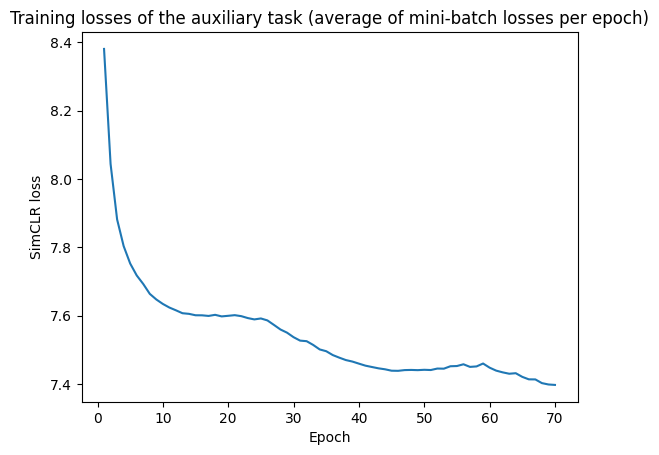

In [ ]:
# plot the training results
log_dir = "/content/gdrive/MyDrive/ColabNotebooks/IFT6135/Devoir3/Devoir3/log_memory_v2"
import numpy as np
import os
import matplotlib.pyplot as plt
import json

#load the logs
log_path = os.path.join(log_dir, f"args.json")
with open(log_path, 'r') as f:
        logs = json.load(f)
# Extract data from logs
train_results= logs["train_losses"]
# plot the training losses per epoch
plt.plot(range(1,71), train_results)
plt.title('Training losses of the auxiliary task (average of mini-batch losses per epoch)')
plt.xlabel('Epoch')
plt.ylabel('SimCLR loss')
plt.show()

# Step 3: Evaluate on the down-stream task: Train a new MLP decoder based on the trained encoder.

This finetune process should be way faster than the previous one. The expected Top-1 accuracy should be around 57% and the Top-5 accuracy should be around 97%. Getting this results is normal because linear prob is just a projection layer usually recognized as not having representation ability. To achieve the performance mentioned in the paper, we need larger dataset and more powerful GPU and longer time (about 1000 epoches during the pretraining stage).

In [ ]:
class linear_prob_Trainer:
    def __init__(self, *args, **kwargs):
        self.args = kwargs["args"]
        self.model = kwargs["model"].to(self.args.device)
        self.optimizer = kwargs["optimizer"]
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)
        self.train_dataset = datasets.STL10(
            "./data", split="train", download=True, transform=transforms.ToTensor()
        )

        self.train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.args.batch_size,
            num_workers=1,
            drop_last=False,
        )

        self.test_dataset = datasets.STL10(
            "./data", split="test", download=True, transform=transforms.ToTensor()
        )

        self.test_loader = torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.args.batch_size,
            num_workers=1,
            drop_last=False,
        )

    def accuracy(self, output, target, topk=(1,)):
        with torch.no_grad():
            maxk = max(topk)
            batch_size = target.size(0)

            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.mul_(100.0 / batch_size))
            return res

# train the model on 100 epochs and save the training accuracy after 100 epochs
    def train(self, dataloader, results):
        for epoch in range(100):
            top1_train_accuracy = 0
            for images, labels in tqdm(dataloader):
                images, labels = images.to(self.args.device), labels.to(
                    self.args.device
                )
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                top1 = self.accuracy(logits, labels, topk=(1,))
                top1_train_accuracy += top1[0]

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                print(
                    f"Epoch: {epoch}, Loss: {loss.item()}",
                    "Top1 Train Accuracy: ",
                    top1_train_accuracy.item() / len(dataloader),
                )
        results.append(top1_train_accuracy.item() / len(dataloader))
        return self.model

# test the performance of the trained model and return the test accuracies (top1 and top5)

    def test(self, dataloader):
        with torch.no_grad():
            model.eval()
            results= np.zeros((1, 2))
            step = 0
            top1_test_accuracy = 0
            top5_test_accuracy = 0
            for images, labels in tqdm(dataloader):
                images, labels = images.to(self.args.device), labels.to(
                    self.args.device
                )
                logits = self.model(images)
                top1 = self.accuracy(logits, labels, topk=(1,))
                top1_test_accuracy += top1[0]
                top5 = self.accuracy(logits, labels, topk=(5,))
                top5_test_accuracy += top5[0]
                step += 1
            print("Top1 Test Accuracy: ", top1_test_accuracy.item() / len(dataloader))
            print("Top5 Test Accuracy: ", top5_test_accuracy.item() / len(dataloader))
            results[0, 0] = top1_test_accuracy.item() / len(dataloader)
            results[0, 1] = top5_test_accuracy.item() / len(dataloader)

            return results

Compare the performances of the different simCLR models after training for 10, 20, ... 70 epochs

In [ ]:
log_dir = "/content/gdrive/MyDrive/ColabNotebooks/IFT6135/Devoir3/Devoir3/models_v2"
import numpy as np
import os
train_results = np.zeros((7, 1))
test_results = np.zeros((7, 2))
t = 0
for epoch in range(9,70,10):
  print(f"epoch {epoch+1}")
  #load the model
  log_path = os.path.join(log_dir, f"model_{epoch}.pth")
  model = Net()
  state_dict = torch.load(log_path)
  model.load_state_dict(state_dict)
  model.to(args.device)
  #add a linear probe to the model
  model.linear_probe()
  linear_probe_optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
  # train the linear probe model
  train_accs= []
  linear_prob_trainer = linear_prob_Trainer(args=args, model=model, optimizer=linear_probe_optimizer)
  model = linear_prob_trainer.train(linear_prob_trainer.train_loader,train_accs)
  train_results[t, 0] = train_accs[0]
  #test the model performances on test set
  test_results[t, :] = linear_prob_trainer.test(linear_prob_trainer.test_loader)
  t = t + 1

epoch 10
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/2 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 0, Loss: 2.6363065242767334 Top1 Train Accuracy:  3.613281011581421


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 0, Loss: 2.5704185962677 Top1 Train Accuracy:  7.243986129760742


 50%|█████     | 1/2 [00:02<00:02,  2.39s/it]

Epoch: 1, Loss: 2.497323989868164 Top1 Train Accuracy:  3.564452886581421


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 1, Loss: 2.4401893615722656 Top1 Train Accuracy:  7.506361961364746


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 2, Loss: 2.384538412094116 Top1 Train Accuracy:  4.5735673904418945


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 2, Loss: 2.3340439796447754 Top1 Train Accuracy:  10.40863037109375


 50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

Epoch: 3, Loss: 2.291461944580078 Top1 Train Accuracy:  7.096354007720947


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 3, Loss: 2.2458133697509766 Top1 Train Accuracy:  15.965648651123047


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 4, Loss: 2.212165355682373 Top1 Train Accuracy:  9.098306655883789


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 4, Loss: 2.170213222503662 Top1 Train Accuracy:  18.92714500427246


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 5, Loss: 2.1424643993377686 Top1 Train Accuracy:  10.384114265441895


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 5, Loss: 2.103653907775879 Top1 Train Accuracy:  21.30216407775879


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 6, Loss: 2.079900026321411 Top1 Train Accuracy:  11.181640625


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 6, Loss: 2.044006586074829 Top1 Train Accuracy:  22.799898147583008


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 7, Loss: 2.0232553482055664 Top1 Train Accuracy:  12.044270515441895


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 7, Loss: 1.9901812076568604 Top1 Train Accuracy:  24.336801528930664


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 8, Loss: 1.9721051454544067 Top1 Train Accuracy:  13.020833015441895


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 8, Loss: 1.941765546798706 Top1 Train Accuracy:  26.480377197265625


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 9, Loss: 1.9264130592346191 Top1 Train Accuracy:  13.753254890441895


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 9, Loss: 1.8986679315567017 Top1 Train Accuracy:  28.094541549682617


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 10, Loss: 1.8861517906188965 Top1 Train Accuracy:  14.518228530883789


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 10, Loss: 1.8607531785964966 Top1 Train Accuracy:  29.870925903320312


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 11, Loss: 1.8510123491287231 Top1 Train Accuracy:  15.413411140441895


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 11, Loss: 1.8276187181472778 Top1 Train Accuracy:  30.97357749938965


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 12, Loss: 1.8203439712524414 Top1 Train Accuracy:  16.341144561767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 12, Loss: 1.7986092567443848 Top1 Train Accuracy:  32.70525360107422


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 13, Loss: 1.7933250665664673 Top1 Train Accuracy:  16.9921875


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 13, Loss: 1.7729982137680054 Top1 Train Accuracy:  33.92683410644531


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 14, Loss: 1.7692149877548218 Top1 Train Accuracy:  17.49674415588379


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 14, Loss: 1.7501722574234009 Top1 Train Accuracy:  34.84632873535156


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 15, Loss: 1.7475099563598633 Top1 Train Accuracy:  18.001300811767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 15, Loss: 1.7297024726867676 Top1 Train Accuracy:  35.68802261352539


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 16, Loss: 1.7279281616210938 Top1 Train Accuracy:  18.22916603088379


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 16, Loss: 1.711298942565918 Top1 Train Accuracy:  36.12335968017578


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 17, Loss: 1.7103022336959839 Top1 Train Accuracy:  18.489582061767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 17, Loss: 1.6947369575500488 Top1 Train Accuracy:  36.902442932128906


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 18, Loss: 1.6944851875305176 Top1 Train Accuracy:  18.86393165588379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 18, Loss: 1.679825782775879 Top1 Train Accuracy:  37.4842643737793


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 19, Loss: 1.680315613746643 Top1 Train Accuracy:  19.384765625


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 19, Loss: 1.666398048400879 Top1 Train Accuracy:  38.08290100097656


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 20, Loss: 1.6676100492477417 Top1 Train Accuracy:  19.417316436767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 20, Loss: 1.6542927026748657 Top1 Train Accuracy:  38.50445556640625


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 21, Loss: 1.656166434288025 Top1 Train Accuracy:  19.759113311767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 21, Loss: 1.6433396339416504 Top1 Train Accuracy:  38.924049377441406


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 22, Loss: 1.6457823514938354 Top1 Train Accuracy:  19.88932228088379


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 22, Loss: 1.6333656311035156 Top1 Train Accuracy:  39.3135986328125


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 23, Loss: 1.6362916231155396 Top1 Train Accuracy:  19.905597686767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 23, Loss: 1.6242198944091797 Top1 Train Accuracy:  39.355804443359375


 50%|█████     | 1/2 [00:02<00:02,  2.36s/it]

Epoch: 24, Loss: 1.6275862455368042 Top1 Train Accuracy:  20.13346290588379


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 24, Loss: 1.6157944202423096 Top1 Train Accuracy:  39.73927307128906


 50%|█████     | 1/2 [00:02<00:02,  2.27s/it]

Epoch: 25, Loss: 1.6196118593215942 Top1 Train Accuracy:  20.100910186767578


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch: 25, Loss: 1.6080148220062256 Top1 Train Accuracy:  39.914188385009766


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 26, Loss: 1.6123262643814087 Top1 Train Accuracy:  20.263671875


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 26, Loss: 1.6008206605911255 Top1 Train Accuracy:  40.128814697265625


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 27, Loss: 1.605666995048523 Top1 Train Accuracy:  20.37760353088379


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 27, Loss: 1.5941474437713623 Top1 Train Accuracy:  40.34648132324219


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 28, Loss: 1.5995434522628784 Top1 Train Accuracy:  20.52408790588379


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 28, Loss: 1.587926983833313 Top1 Train Accuracy:  40.44110107421875


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 29, Loss: 1.593856692314148 Top1 Train Accuracy:  20.654296875


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 29, Loss: 1.582104206085205 Top1 Train Accuracy:  40.64910888671875


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 30, Loss: 1.5885323286056519 Top1 Train Accuracy:  20.57291603088379


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 30, Loss: 1.5766427516937256 Top1 Train Accuracy:  40.852996826171875


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 31, Loss: 1.583532452583313 Top1 Train Accuracy:  20.638019561767578


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 31, Loss: 1.5715185403823853 Top1 Train Accuracy:  41.02183532714844


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 32, Loss: 1.5788426399230957 Top1 Train Accuracy:  20.735675811767578


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch: 32, Loss: 1.5667020082473755 Top1 Train Accuracy:  41.11949157714844


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 33, Loss: 1.574449896812439 Top1 Train Accuracy:  20.80078125


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 33, Loss: 1.5621495246887207 Top1 Train Accuracy:  41.10679626464844


 50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

Epoch: 34, Loss: 1.5703309774398804 Top1 Train Accuracy:  20.930988311767578


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 34, Loss: 1.5578149557113647 Top1 Train Accuracy:  41.31480407714844


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 35, Loss: 1.56645667552948 Top1 Train Accuracy:  21.09375


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 35, Loss: 1.5536669492721558 Top1 Train Accuracy:  41.607234954833984


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 36, Loss: 1.5627998113632202 Top1 Train Accuracy:  21.25650978088379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 36, Loss: 1.5496916770935059 Top1 Train Accuracy:  41.92559814453125


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 37, Loss: 1.5593371391296387 Top1 Train Accuracy:  21.321613311767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 37, Loss: 1.545886516571045 Top1 Train Accuracy:  42.12036895751953


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 38, Loss: 1.556046485900879 Top1 Train Accuracy:  21.370441436767578


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 38, Loss: 1.5422470569610596 Top1 Train Accuracy:  42.350730895996094


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 39, Loss: 1.5529073476791382 Top1 Train Accuracy:  21.40299415588379


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 39, Loss: 1.538763165473938 Top1 Train Accuracy:  42.59075164794922


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 40, Loss: 1.5499027967453003 Top1 Train Accuracy:  21.50065040588379


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 40, Loss: 1.5354208946228027 Top1 Train Accuracy:  42.89588165283203


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 41, Loss: 1.547021746635437 Top1 Train Accuracy:  21.533203125


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 41, Loss: 1.5322048664093018 Top1 Train Accuracy:  43.03216552734375


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 42, Loss: 1.544256567955017 Top1 Train Accuracy:  21.516925811767578


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 42, Loss: 1.5291030406951904 Top1 Train Accuracy:  43.04182434082031


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 43, Loss: 1.541601300239563 Top1 Train Accuracy:  21.58203125


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 43, Loss: 1.526105284690857 Top1 Train Accuracy:  43.08099365234375


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 44, Loss: 1.5390490293502808 Top1 Train Accuracy:  21.64713478088379


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 44, Loss: 1.5232059955596924 Top1 Train Accuracy:  43.24983215332031


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 45, Loss: 1.5365900993347168 Top1 Train Accuracy:  21.663410186767578


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 45, Loss: 1.5204004049301147 Top1 Train Accuracy:  43.31797409057617


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 46, Loss: 1.5342150926589966 Top1 Train Accuracy:  21.74479103088379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 46, Loss: 1.517683982849121 Top1 Train Accuracy:  43.45122528076172


 50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

Epoch: 47, Loss: 1.531915545463562 Top1 Train Accuracy:  21.79361915588379


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 47, Loss: 1.5150529146194458 Top1 Train Accuracy:  43.42224884033203


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 48, Loss: 1.5296845436096191 Top1 Train Accuracy:  22.005207061767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 48, Loss: 1.5125004053115845 Top1 Train Accuracy:  43.737571716308594


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 49, Loss: 1.5275198221206665 Top1 Train Accuracy:  22.03775978088379


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 49, Loss: 1.510021686553955 Top1 Train Accuracy:  43.796058654785156


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 50, Loss: 1.5254169702529907 Top1 Train Accuracy:  21.956378936767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 50, Loss: 1.5076102018356323 Top1 Train Accuracy:  43.766544342041016


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 51, Loss: 1.5233731269836426 Top1 Train Accuracy:  22.005207061767578


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 51, Loss: 1.5052615404129028 Top1 Train Accuracy:  43.7894401550293


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 52, Loss: 1.5213847160339355 Top1 Train Accuracy:  21.98893165588379


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 52, Loss: 1.5029720067977905 Top1 Train Accuracy:  43.92876434326172


 50%|█████     | 1/2 [00:02<00:02,  2.36s/it]

Epoch: 53, Loss: 1.5194488763809204 Top1 Train Accuracy:  21.97265625


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 53, Loss: 1.5007379055023193 Top1 Train Accuracy:  43.886558532714844


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 54, Loss: 1.517561435699463 Top1 Train Accuracy:  21.97265625


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 54, Loss: 1.4985568523406982 Top1 Train Accuracy:  43.91249084472656


 50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

Epoch: 55, Loss: 1.515718936920166 Top1 Train Accuracy:  22.054035186767578


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 55, Loss: 1.4964255094528198 Top1 Train Accuracy:  43.99386978149414


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 56, Loss: 1.5139189958572388 Top1 Train Accuracy:  22.08658790588379


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 56, Loss: 1.4943419694900513 Top1 Train Accuracy:  44.07828903198242


 50%|█████     | 1/2 [00:02<00:02,  2.36s/it]

Epoch: 57, Loss: 1.5121593475341797 Top1 Train Accuracy:  22.151691436767578


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 57, Loss: 1.492303490638733 Top1 Train Accuracy:  44.117462158203125


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 58, Loss: 1.5104361772537231 Top1 Train Accuracy:  22.200519561767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 58, Loss: 1.4903087615966797 Top1 Train Accuracy:  44.21815490722656


 50%|█████     | 1/2 [00:02<00:02,  2.36s/it]

Epoch: 59, Loss: 1.508748173713684 Top1 Train Accuracy:  22.216796875


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 59, Loss: 1.488355040550232 Top1 Train Accuracy:  44.20849609375


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 60, Loss: 1.5070923566818237 Top1 Train Accuracy:  22.216796875


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 60, Loss: 1.4864407777786255 Top1 Train Accuracy:  44.234432220458984


 50%|█████     | 1/2 [00:02<00:02,  2.27s/it]

Epoch: 61, Loss: 1.5054680109024048 Top1 Train Accuracy:  22.216796875


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch: 61, Loss: 1.4845634698867798 Top1 Train Accuracy:  44.234432220458984


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 62, Loss: 1.5038734674453735 Top1 Train Accuracy:  22.200519561767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 62, Loss: 1.4827206134796143 Top1 Train Accuracy:  44.399688720703125


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 63, Loss: 1.5023082494735718 Top1 Train Accuracy:  22.298175811767578


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 63, Loss: 1.4809099435806274 Top1 Train Accuracy:  44.62701416015625


 50%|█████     | 1/2 [00:02<00:02,  2.38s/it]

Epoch: 64, Loss: 1.5007710456848145 Top1 Train Accuracy:  22.314453125


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 64, Loss: 1.479130506515503 Top1 Train Accuracy:  44.695159912109375


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 65, Loss: 1.4992598295211792 Top1 Train Accuracy:  22.314453125


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 65, Loss: 1.4773807525634766 Top1 Train Accuracy:  44.669227600097656


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 66, Loss: 1.497773289680481 Top1 Train Accuracy:  22.314453125


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 66, Loss: 1.4756603240966797 Top1 Train Accuracy:  44.721092224121094


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 67, Loss: 1.4963096380233765 Top1 Train Accuracy:  22.347003936767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 67, Loss: 1.473968267440796 Top1 Train Accuracy:  44.88330841064453


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 68, Loss: 1.4948664903640747 Top1 Train Accuracy:  22.42838478088379


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 68, Loss: 1.4723045825958252 Top1 Train Accuracy:  45.01655960083008


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 69, Loss: 1.4934438467025757 Top1 Train Accuracy:  22.444660186767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 69, Loss: 1.470666766166687 Top1 Train Accuracy:  45.05876922607422


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 70, Loss: 1.492040753364563 Top1 Train Accuracy:  22.4609375


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 70, Loss: 1.4690536260604858 Top1 Train Accuracy:  45.10097885131836


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 71, Loss: 1.4906567335128784 Top1 Train Accuracy:  22.509765625


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 71, Loss: 1.4674642086029053 Top1 Train Accuracy:  45.22760772705078


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 72, Loss: 1.4892915487289429 Top1 Train Accuracy:  22.542316436767578


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 72, Loss: 1.4658962488174438 Top1 Train Accuracy:  45.31202697753906


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 73, Loss: 1.48794424533844 Top1 Train Accuracy:  22.542316436767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 73, Loss: 1.4643502235412598 Top1 Train Accuracy:  45.389827728271484


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 74, Loss: 1.4866142272949219 Top1 Train Accuracy:  22.591144561767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 74, Loss: 1.462825059890747 Top1 Train Accuracy:  45.49052429199219


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 75, Loss: 1.4853005409240723 Top1 Train Accuracy:  22.591144561767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 75, Loss: 1.4613205194473267 Top1 Train Accuracy:  45.49052429199219


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 76, Loss: 1.484001636505127 Top1 Train Accuracy:  22.688800811767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 76, Loss: 1.4598358869552612 Top1 Train Accuracy:  45.58818054199219


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 77, Loss: 1.482716679573059 Top1 Train Accuracy:  22.737628936767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 77, Loss: 1.4583704471588135 Top1 Train Accuracy:  45.688873291015625


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 78, Loss: 1.4814461469650269 Top1 Train Accuracy:  22.786457061767578


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 78, Loss: 1.4569231271743774 Top1 Train Accuracy:  45.763633728027344


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 79, Loss: 1.4801898002624512 Top1 Train Accuracy:  22.737628936767578


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 79, Loss: 1.4554933309555054 Top1 Train Accuracy:  45.76667404174805


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 80, Loss: 1.478946328163147 Top1 Train Accuracy:  22.77018165588379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 80, Loss: 1.4540798664093018 Top1 Train Accuracy:  45.82516098022461


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 81, Loss: 1.4777164459228516 Top1 Train Accuracy:  22.75390625


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 81, Loss: 1.4526830911636353 Top1 Train Accuracy:  45.78295135498047


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 82, Loss: 1.476499080657959 Top1 Train Accuracy:  22.77018165588379


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 82, Loss: 1.4513013362884521 Top1 Train Accuracy:  45.92889404296875


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 83, Loss: 1.4752936363220215 Top1 Train Accuracy:  22.802734375


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 83, Loss: 1.4499351978302002 Top1 Train Accuracy:  45.98738098144531


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 84, Loss: 1.4740996360778809 Top1 Train Accuracy:  22.81900978088379


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 84, Loss: 1.448583722114563 Top1 Train Accuracy:  45.97772216796875


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 85, Loss: 1.472917079925537 Top1 Train Accuracy:  22.835285186767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 85, Loss: 1.4472465515136719 Top1 Train Accuracy:  45.99399948120117


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 86, Loss: 1.4717453718185425 Top1 Train Accuracy:  22.884113311767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 86, Loss: 1.4459227323532104 Top1 Train Accuracy:  46.094696044921875


 50%|█████     | 1/2 [00:02<00:02,  2.27s/it]

Epoch: 87, Loss: 1.470584511756897 Top1 Train Accuracy:  22.884113311767578


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch: 87, Loss: 1.4446125030517578 Top1 Train Accuracy:  46.14656066894531


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 88, Loss: 1.469434380531311 Top1 Train Accuracy:  22.900390625


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 88, Loss: 1.4433146715164185 Top1 Train Accuracy:  46.21470642089844


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 89, Loss: 1.4682945013046265 Top1 Train Accuracy:  22.932941436767578


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 89, Loss: 1.4420294761657715 Top1 Train Accuracy:  46.350990295410156


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 90, Loss: 1.467164397239685 Top1 Train Accuracy:  22.981769561767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 90, Loss: 1.440755844116211 Top1 Train Accuracy:  46.425750732421875


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 91, Loss: 1.466043472290039 Top1 Train Accuracy:  23.079425811767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 91, Loss: 1.4394943714141846 Top1 Train Accuracy:  46.497474670410156


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 92, Loss: 1.4649324417114258 Top1 Train Accuracy:  23.11197853088379


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 92, Loss: 1.4382438659667969 Top1 Train Accuracy:  46.63376235961914


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 93, Loss: 1.4638303518295288 Top1 Train Accuracy:  23.128253936767578


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 93, Loss: 1.4370049238204956 Top1 Train Accuracy:  46.701904296875


 50%|█████     | 1/2 [00:02<00:02,  2.41s/it]

Epoch: 94, Loss: 1.4627372026443481 Top1 Train Accuracy:  23.128253936767578


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Epoch: 94, Loss: 1.4357762336730957 Top1 Train Accuracy:  46.77970886230469


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 95, Loss: 1.4616526365280151 Top1 Train Accuracy:  23.11197853088379


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 95, Loss: 1.4345581531524658 Top1 Train Accuracy:  46.73749542236328


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 96, Loss: 1.4605768918991089 Top1 Train Accuracy:  23.14453125


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 96, Loss: 1.4333497285842896 Top1 Train Accuracy:  46.71818542480469


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 97, Loss: 1.459509253501892 Top1 Train Accuracy:  23.177082061767578


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 97, Loss: 1.4321516752243042 Top1 Train Accuracy:  46.77666473388672


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 98, Loss: 1.4584494829177856 Top1 Train Accuracy:  23.20963478088379


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 98, Loss: 1.4309626817703247 Top1 Train Accuracy:  46.83515167236328


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 99, Loss: 1.4573975801467896 Top1 Train Accuracy:  23.193359375


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 99, Loss: 1.4297833442687988 Top1 Train Accuracy:  46.818878173828125


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Top1 Test Accuracy:  45.0816396077474
Top5 Test Accuracy:  92.94181315104167
epoch 20
Files already downloaded and verified
Files already downloaded and verified


 50%|█████     | 1/2 [00:02<00:02,  2.37s/it]

Epoch: 0, Loss: 2.4268343448638916 Top1 Train Accuracy:  4.459635257720947


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 0, Loss: 2.367398262023926 Top1 Train Accuracy:  9.646357536315918


 50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

Epoch: 1, Loss: 2.3107824325561523 Top1 Train Accuracy:  5.1106767654418945


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 1, Loss: 2.2616450786590576 Top1 Train Accuracy:  10.842004776000977


 50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

Epoch: 2, Loss: 2.2167255878448486 Top1 Train Accuracy:  6.852213382720947


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 2, Loss: 2.174492835998535 Top1 Train Accuracy:  15.82524299621582


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 3, Loss: 2.1384260654449463 Top1 Train Accuracy:  10.302734375


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 3, Loss: 2.1008291244506836 Top1 Train Accuracy:  21.869125366210938


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 4, Loss: 2.071251153945923 Top1 Train Accuracy:  11.865234375


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 4, Loss: 2.036916732788086 Top1 Train Accuracy:  25.013574600219727


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 5, Loss: 2.0122482776641846 Top1 Train Accuracy:  13.427733421325684


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 5, Loss: 1.9805481433868408 Top1 Train Accuracy:  27.224414825439453


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 6, Loss: 1.9598478078842163 Top1 Train Accuracy:  14.632161140441895


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 6, Loss: 1.930550456047058 Top1 Train Accuracy:  29.673656463623047


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 7, Loss: 1.913203239440918 Top1 Train Accuracy:  15.478514671325684


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 7, Loss: 1.8862011432647705 Top1 Train Accuracy:  31.323951721191406


 50%|█████     | 1/2 [00:02<00:02,  2.37s/it]

Epoch: 8, Loss: 1.8717044591903687 Top1 Train Accuracy:  16.015625


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 8, Loss: 1.84690260887146 Top1 Train Accuracy:  32.48346710205078


 50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

Epoch: 9, Loss: 1.834814429283142 Top1 Train Accuracy:  16.42252540588379


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 9, Loss: 1.8121418952941895 Top1 Train Accuracy:  33.27937316894531


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 10, Loss: 1.8021035194396973 Top1 Train Accuracy:  16.9921875


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 10, Loss: 1.7815065383911133 Top1 Train Accuracy:  34.160240173339844


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 11, Loss: 1.7732280492782593 Top1 Train Accuracy:  17.513019561767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 11, Loss: 1.7546054124832153 Top1 Train Accuracy:  34.603271484375


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 12, Loss: 1.7478193044662476 Top1 Train Accuracy:  17.64322853088379


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 12, Loss: 1.7309608459472656 Top1 Train Accuracy:  34.940948486328125


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 13, Loss: 1.7254170179367065 Top1 Train Accuracy:  18.147785186767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 13, Loss: 1.71001136302948 Top1 Train Accuracy:  35.75670623779297


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 14, Loss: 1.7055245637893677 Top1 Train Accuracy:  18.37565040588379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 14, Loss: 1.6912249326705933 Top1 Train Accuracy:  36.2957763671875


 50%|█████     | 1/2 [00:02<00:02,  2.37s/it]

Epoch: 15, Loss: 1.687726378440857 Top1 Train Accuracy:  18.684894561767578


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 15, Loss: 1.6742132902145386 Top1 Train Accuracy:  36.96809005737305


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 16, Loss: 1.671737790107727 Top1 Train Accuracy:  18.84765625


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 16, Loss: 1.6587449312210083 Top1 Train Accuracy:  37.28645324707031


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 17, Loss: 1.6573680639266968 Top1 Train Accuracy:  18.977863311767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 17, Loss: 1.6446843147277832 Top1 Train Accuracy:  37.77973175048828


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 18, Loss: 1.6444534063339233 Top1 Train Accuracy:  19.25455665588379


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 18, Loss: 1.6319193840026855 Top1 Train Accuracy:  38.186092376708984


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 19, Loss: 1.6328181028366089 Top1 Train Accuracy:  19.43359375


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 19, Loss: 1.6203242540359497 Top1 Train Accuracy:  38.831932067871094


 50%|█████     | 1/2 [00:02<00:02,  2.37s/it]

Epoch: 20, Loss: 1.6222783327102661 Top1 Train Accuracy:  19.612628936767578


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 20, Loss: 1.6097618341445923 Top1 Train Accuracy:  39.27030563354492


 50%|█████     | 1/2 [00:02<00:02,  2.36s/it]

Epoch: 21, Loss: 1.6126703023910522 Top1 Train Accuracy:  19.775390625


100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Epoch: 21, Loss: 1.6001032590866089 Top1 Train Accuracy:  39.66646957397461


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 22, Loss: 1.6038684844970703 Top1 Train Accuracy:  20.068359375


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 22, Loss: 1.5912410020828247 Top1 Train Accuracy:  40.29657745361328


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 23, Loss: 1.595784068107605 Top1 Train Accuracy:  20.27994728088379


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 23, Loss: 1.583081603050232 Top1 Train Accuracy:  40.534095764160156


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 24, Loss: 1.5883427858352661 Top1 Train Accuracy:  20.42643165588379


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 24, Loss: 1.575537085533142 Top1 Train Accuracy:  40.73244857788086


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 25, Loss: 1.5814710855484009 Top1 Train Accuracy:  20.57291603088379


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 25, Loss: 1.568523645401001 Top1 Train Accuracy:  40.95673370361328


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 26, Loss: 1.5750945806503296 Top1 Train Accuracy:  20.654296875


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 26, Loss: 1.5619707107543945 Top1 Train Accuracy:  41.064048767089844


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 27, Loss: 1.569151520729065 Top1 Train Accuracy:  20.62174415588379


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 27, Loss: 1.5558253526687622 Top1 Train Accuracy:  41.05742645263672


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 28, Loss: 1.5635982751846313 Top1 Train Accuracy:  20.638019561767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 28, Loss: 1.5500521659851074 Top1 Train Accuracy:  41.307106018066406


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 29, Loss: 1.558402419090271 Top1 Train Accuracy:  20.76822853088379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 29, Loss: 1.5446194410324097 Top1 Train Accuracy:  41.54104995727539


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 30, Loss: 1.5535316467285156 Top1 Train Accuracy:  20.96354103088379


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 30, Loss: 1.5394917726516724 Top1 Train Accuracy:  41.866031646728516


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 31, Loss: 1.5489507913589478 Top1 Train Accuracy:  21.09375


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 31, Loss: 1.5346347093582153 Top1 Train Accuracy:  42.12590789794922


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 32, Loss: 1.5446254014968872 Top1 Train Accuracy:  21.126300811767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 32, Loss: 1.530019760131836 Top1 Train Accuracy:  42.2103271484375


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 33, Loss: 1.54052734375 Top1 Train Accuracy:  21.240234375


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 33, Loss: 1.525625467300415 Top1 Train Accuracy:  42.42799377441406


 50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

Epoch: 34, Loss: 1.5366325378417969 Top1 Train Accuracy:  21.2890625


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 34, Loss: 1.5214333534240723 Top1 Train Accuracy:  42.60649108886719


 50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

Epoch: 35, Loss: 1.532921314239502 Top1 Train Accuracy:  21.337890625


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 35, Loss: 1.5174245834350586 Top1 Train Accuracy:  42.75905227661133


 50%|█████     | 1/2 [00:02<00:02,  2.36s/it]

Epoch: 36, Loss: 1.5293787717819214 Top1 Train Accuracy:  21.35416603088379


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 36, Loss: 1.5135806798934937 Top1 Train Accuracy:  42.87906265258789


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 37, Loss: 1.5259901285171509 Top1 Train Accuracy:  21.484375


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 37, Loss: 1.5098870992660522 Top1 Train Accuracy:  43.00926971435547


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 38, Loss: 1.5227441787719727 Top1 Train Accuracy:  21.484375


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 38, Loss: 1.5063307285308838 Top1 Train Accuracy:  43.113006591796875


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 39, Loss: 1.5196274518966675 Top1 Train Accuracy:  21.54947853088379


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 39, Loss: 1.5029010772705078 Top1 Train Accuracy:  43.333709716796875


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 40, Loss: 1.5166267156600952 Top1 Train Accuracy:  21.6796875


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 40, Loss: 1.49959135055542 Top1 Train Accuracy:  43.54172134399414


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 41, Loss: 1.513730525970459 Top1 Train Accuracy:  21.69596290588379


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 41, Loss: 1.4963940382003784 Top1 Train Accuracy:  43.58393096923828


 50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

Epoch: 42, Loss: 1.5109295845031738 Top1 Train Accuracy:  21.6796875


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 42, Loss: 1.4933006763458252 Top1 Train Accuracy:  43.64545440673828


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 43, Loss: 1.5082169771194458 Top1 Train Accuracy:  21.761066436767578


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 43, Loss: 1.4903022050857544 Top1 Train Accuracy:  43.80463409423828


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 44, Loss: 1.5055885314941406 Top1 Train Accuracy:  21.79361915588379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 44, Loss: 1.4873896837234497 Top1 Train Accuracy:  43.940921783447266


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 45, Loss: 1.5030399560928345 Top1 Train Accuracy:  21.77734375


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 45, Loss: 1.4845565557479858 Top1 Train Accuracy:  43.95058059692383


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 46, Loss: 1.5005664825439453 Top1 Train Accuracy:  21.79361915588379


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 46, Loss: 1.4817975759506226 Top1 Train Accuracy:  44.044654846191406


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 47, Loss: 1.4981623888015747 Top1 Train Accuracy:  21.89127540588379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 47, Loss: 1.4791102409362793 Top1 Train Accuracy:  44.142311096191406


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 48, Loss: 1.495821475982666 Top1 Train Accuracy:  21.94010353088379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 48, Loss: 1.4764915704727173 Top1 Train Accuracy:  44.24300765991211


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 49, Loss: 1.4935377836227417 Top1 Train Accuracy:  22.005207061767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 49, Loss: 1.4739384651184082 Top1 Train Accuracy:  44.38591003417969


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 50, Loss: 1.4913076162338257 Top1 Train Accuracy:  22.0703125


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 50, Loss: 1.47144615650177 Top1 Train Accuracy:  44.451019287109375


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 51, Loss: 1.4891290664672852 Top1 Train Accuracy:  22.200519561767578


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 51, Loss: 1.469010353088379 Top1 Train Accuracy:  44.71089172363281


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 52, Loss: 1.487000823020935 Top1 Train Accuracy:  22.200519561767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 52, Loss: 1.4666259288787842 Top1 Train Accuracy:  44.762760162353516


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 53, Loss: 1.4849214553833008 Top1 Train Accuracy:  22.23307228088379


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 53, Loss: 1.4642890691757202 Top1 Train Accuracy:  44.84718322753906


 50%|█████     | 1/2 [00:02<00:02,  2.38s/it]

Epoch: 54, Loss: 1.482889175415039 Top1 Train Accuracy:  22.314453125


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 54, Loss: 1.461997628211975 Top1 Train Accuracy:  44.980430603027344


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 55, Loss: 1.4809002876281738 Top1 Train Accuracy:  22.298175811767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 55, Loss: 1.459751009941101 Top1 Train Accuracy:  45.01601791381836


 50%|█████     | 1/2 [00:02<00:02,  2.38s/it]

Epoch: 56, Loss: 1.478951334953308 Top1 Train Accuracy:  22.347003936767578


100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Epoch: 56, Loss: 1.457547903060913 Top1 Train Accuracy:  45.03891372680664


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 57, Loss: 1.477038860321045 Top1 Train Accuracy:  22.37955665588379


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 57, Loss: 1.455388069152832 Top1 Train Accuracy:  45.09739685058594


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 58, Loss: 1.475160002708435 Top1 Train Accuracy:  22.42838478088379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 58, Loss: 1.4532701969146729 Top1 Train Accuracy:  45.17216110229492


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 59, Loss: 1.473312497138977 Top1 Train Accuracy:  22.42838478088379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 59, Loss: 1.4511916637420654 Top1 Train Accuracy:  45.198097229003906


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 60, Loss: 1.4714956283569336 Top1 Train Accuracy:  22.4609375


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 60, Loss: 1.4491509199142456 Top1 Train Accuracy:  45.230648040771484


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 61, Loss: 1.4697084426879883 Top1 Train Accuracy:  22.509765625


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 61, Loss: 1.4471449851989746 Top1 Train Accuracy:  45.22760772705078


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 62, Loss: 1.4679509401321411 Top1 Train Accuracy:  22.607421875


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 62, Loss: 1.4451714754104614 Top1 Train Accuracy:  45.32526397705078


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 63, Loss: 1.4662224054336548 Top1 Train Accuracy:  22.688800811767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 63, Loss: 1.443229079246521 Top1 Train Accuracy:  45.432579040527344


 50%|█████     | 1/2 [00:02<00:02,  2.40s/it]

Epoch: 64, Loss: 1.4645212888717651 Top1 Train Accuracy:  22.737628936767578


100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Epoch: 64, Loss: 1.441316843032837 Top1 Train Accuracy:  45.45547103881836


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 65, Loss: 1.4628459215164185 Top1 Train Accuracy:  22.786457061767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 65, Loss: 1.4394334554672241 Top1 Train Accuracy:  45.6080322265625


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 66, Loss: 1.4611955881118774 Top1 Train Accuracy:  22.81900978088379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 66, Loss: 1.437578558921814 Top1 Train Accuracy:  45.640586853027344


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 67, Loss: 1.4595685005187988 Top1 Train Accuracy:  22.835285186767578


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 67, Loss: 1.4357510805130005 Top1 Train Accuracy:  45.7087287902832


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 68, Loss: 1.457964301109314 Top1 Train Accuracy:  22.835285186767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 68, Loss: 1.4339491128921509 Top1 Train Accuracy:  45.73466491699219


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 69, Loss: 1.4563817977905273 Top1 Train Accuracy:  22.786457061767578


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 69, Loss: 1.432172179222107 Top1 Train Accuracy:  45.81550216674805


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 70, Loss: 1.454820990562439 Top1 Train Accuracy:  22.8515625


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 70, Loss: 1.4304193258285522 Top1 Train Accuracy:  45.984344482421875


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 71, Loss: 1.453281283378601 Top1 Train Accuracy:  22.884113311767578


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 71, Loss: 1.428688645362854 Top1 Train Accuracy:  46.04282760620117


 50%|█████     | 1/2 [00:02<00:02,  2.38s/it]

Epoch: 72, Loss: 1.451761245727539 Top1 Train Accuracy:  22.884113311767578


100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Epoch: 72, Loss: 1.4269801378250122 Top1 Train Accuracy:  46.068763732910156


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 73, Loss: 1.4502609968185425 Top1 Train Accuracy:  22.884113311767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 73, Loss: 1.4252934455871582 Top1 Train Accuracy:  46.094696044921875


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 74, Loss: 1.4487786293029785 Top1 Train Accuracy:  22.91666603088379


100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Epoch: 74, Loss: 1.423627495765686 Top1 Train Accuracy:  46.15318298339844


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 75, Loss: 1.447313904762268 Top1 Train Accuracy:  22.96549415588379


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 75, Loss: 1.421981692314148 Top1 Train Accuracy:  46.20201110839844


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 76, Loss: 1.4458667039871216 Top1 Train Accuracy:  22.96549415588379


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 76, Loss: 1.4203559160232544 Top1 Train Accuracy:  46.227943420410156


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 77, Loss: 1.4444364309310913 Top1 Train Accuracy:  22.94921875


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch: 77, Loss: 1.418748140335083 Top1 Train Accuracy:  46.23760223388672


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 78, Loss: 1.4430222511291504 Top1 Train Accuracy:  23.046875


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 78, Loss: 1.417158842086792 Top1 Train Accuracy:  46.49085998535156


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 79, Loss: 1.4416241645812988 Top1 Train Accuracy:  23.079425811767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 79, Loss: 1.4155869483947754 Top1 Train Accuracy:  46.54934310913086


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 80, Loss: 1.4402409791946411 Top1 Train Accuracy:  23.095703125


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 80, Loss: 1.4140323400497437 Top1 Train Accuracy:  46.6434211730957


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 81, Loss: 1.4388729333877563 Top1 Train Accuracy:  23.11197853088379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 81, Loss: 1.4124946594238281 Top1 Train Accuracy:  46.71156311035156


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 82, Loss: 1.4375187158584595 Top1 Train Accuracy:  23.128253936767578


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 82, Loss: 1.410973310470581 Top1 Train Accuracy:  46.7537727355957


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 83, Loss: 1.4361785650253296 Top1 Train Accuracy:  23.11197853088379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 83, Loss: 1.4094676971435547 Top1 Train Accuracy:  46.763431549072266


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 84, Loss: 1.4348520040512085 Top1 Train Accuracy:  23.095703125


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 84, Loss: 1.4079772233963013 Top1 Train Accuracy:  46.79902267456055


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 85, Loss: 1.4335384368896484 Top1 Train Accuracy:  23.095703125


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 85, Loss: 1.4065020084381104 Top1 Train Accuracy:  46.87682342529297


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 86, Loss: 1.4322375059127808 Top1 Train Accuracy:  23.11197853088379


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 86, Loss: 1.405040979385376 Top1 Train Accuracy:  46.97090148925781


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 87, Loss: 1.4309495687484741 Top1 Train Accuracy:  23.128253936767578


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 87, Loss: 1.4035941362380981 Top1 Train Accuracy:  47.01310729980469


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 88, Loss: 1.4296733140945435 Top1 Train Accuracy:  23.177082061767578


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 88, Loss: 1.4021611213684082 Top1 Train Accuracy:  47.06193542480469


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 89, Loss: 1.428409457206726 Top1 Train Accuracy:  23.16080665588379


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 89, Loss: 1.4007412195205688 Top1 Train Accuracy:  47.12346267700195


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 90, Loss: 1.4271565675735474 Top1 Train Accuracy:  23.193359375


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Epoch: 90, Loss: 1.39933443069458 Top1 Train Accuracy:  47.15601348876953


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 91, Loss: 1.4259155988693237 Top1 Train Accuracy:  23.193359375


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 91, Loss: 1.3979411125183105 Top1 Train Accuracy:  47.23381805419922


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 92, Loss: 1.424685001373291 Top1 Train Accuracy:  23.193359375


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 92, Loss: 1.396559476852417 Top1 Train Accuracy:  47.207881927490234


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 93, Loss: 1.423465371131897 Top1 Train Accuracy:  23.20963478088379


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch: 93, Loss: 1.3951905965805054 Top1 Train Accuracy:  47.250091552734375


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 94, Loss: 1.4222561120986938 Top1 Train Accuracy:  23.2421875


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch: 94, Loss: 1.3938329219818115 Top1 Train Accuracy:  47.30857849121094


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 95, Loss: 1.4210577011108398 Top1 Train Accuracy:  23.2421875


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 95, Loss: 1.3924874067306519 Top1 Train Accuracy:  47.360443115234375


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 96, Loss: 1.419869065284729 Top1 Train Accuracy:  23.25846290588379


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 96, Loss: 1.3911526203155518 Top1 Train Accuracy:  47.40265655517578


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 97, Loss: 1.4186903238296509 Top1 Train Accuracy:  23.291015625


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 97, Loss: 1.389829158782959 Top1 Train Accuracy:  47.43520736694336


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 98, Loss: 1.417521357536316 Top1 Train Accuracy:  23.323566436767578


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Epoch: 98, Loss: 1.3885166645050049 Top1 Train Accuracy:  47.46775817871094


 50%|█████     | 1/2 [00:02<00:02,  2.35s/it]

Epoch: 99, Loss: 1.416361689567566 Top1 Train Accuracy:  23.35611915588379


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Epoch: 99, Loss: 1.3872145414352417 Top1 Train Accuracy:  47.5262451171875


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Top1 Test Accuracy:  46.640401204427086
Top5 Test Accuracy:  93.6384989420573
epoch 30
Files already downloaded and verified
Files already downloaded and verified


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 0, Loss: 2.5761749744415283 Top1 Train Accuracy:  2.4251301288604736


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 0, Loss: 2.524111270904541 Top1 Train Accuracy:  5.251893997192383


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 1, Loss: 2.445969343185425 Top1 Train Accuracy:  3.173827886581421


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 1, Loss: 2.4034781455993652 Top1 Train Accuracy:  6.856400489807129


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 2, Loss: 2.3383381366729736 Top1 Train Accuracy:  4.410807132720947


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 2, Loss: 2.3020639419555664 Top1 Train Accuracy:  9.260392189025879


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 3, Loss: 2.2466022968292236 Top1 Train Accuracy:  5.908203125


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 3, Loss: 2.2142860889434814 Top1 Train Accuracy:  12.521273612976074


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 4, Loss: 2.165853261947632 Top1 Train Accuracy:  7.438150882720947


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 4, Loss: 2.1361467838287354 Top1 Train Accuracy:  15.425703048706055


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 5, Loss: 2.0929417610168457 Top1 Train Accuracy:  9.000650405883789


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 5, Loss: 2.065304756164551 Top1 Train Accuracy:  18.544219970703125


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 6, Loss: 2.0262787342071533 Top1 Train Accuracy:  11.002603530883789


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 6, Loss: 2.000692844390869 Top1 Train Accuracy:  22.154056549072266


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 7, Loss: 1.9652849435806274 Top1 Train Accuracy:  12.630208015441895


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 7, Loss: 1.9419161081314087 Top1 Train Accuracy:  25.49327850341797


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 8, Loss: 1.909798264503479 Top1 Train Accuracy:  14.192708015441895


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 8, Loss: 1.8887544870376587 Top1 Train Accuracy:  28.404327392578125


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 9, Loss: 1.8596771955490112 Top1 Train Accuracy:  15.315754890441895


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 9, Loss: 1.8409020900726318 Top1 Train Accuracy:  30.772186279296875


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 10, Loss: 1.8146400451660156 Top1 Train Accuracy:  16.487628936767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 10, Loss: 1.7979227304458618 Top1 Train Accuracy:  33.00733947753906


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 11, Loss: 1.774271845817566 Top1 Train Accuracy:  17.659503936767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 11, Loss: 1.759300947189331 Top1 Train Accuracy:  35.24249267578125


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 12, Loss: 1.7380863428115845 Top1 Train Accuracy:  18.636066436767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 12, Loss: 1.7245159149169922 Top1 Train Accuracy:  37.67133712768555


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 13, Loss: 1.705592155456543 Top1 Train Accuracy:  19.368488311767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 13, Loss: 1.6930969953536987 Top1 Train Accuracy:  39.20770263671875


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 14, Loss: 1.6763478517532349 Top1 Train Accuracy:  20.068359375


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 14, Loss: 1.6646595001220703 Top1 Train Accuracy:  40.478111267089844


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 15, Loss: 1.6499911546707153 Top1 Train Accuracy:  20.589191436767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 15, Loss: 1.6389061212539673 Top1 Train Accuracy:  41.46574783325195


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 16, Loss: 1.626233696937561 Top1 Train Accuracy:  20.833332061767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 16, Loss: 1.6155997514724731 Top1 Train Accuracy:  41.83955383300781


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 17, Loss: 1.6048332452774048 Top1 Train Accuracy:  21.15885353088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 17, Loss: 1.594527006149292 Top1 Train Accuracy:  42.58001708984375


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 18, Loss: 1.5855664014816284 Top1 Train Accuracy:  21.58203125


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 18, Loss: 1.5754727125167847 Top1 Train Accuracy:  43.184730529785156


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 19, Loss: 1.5682049989700317 Top1 Train Accuracy:  21.74479103088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 19, Loss: 1.5582095384597778 Top1 Train Accuracy:  43.65869140625


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 20, Loss: 1.5525189638137817 Top1 Train Accuracy:  22.216796875


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 20, Loss: 1.5425119400024414 Top1 Train Accuracy:  44.20849609375


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 21, Loss: 1.5382848978042603 Top1 Train Accuracy:  22.265625


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 21, Loss: 1.5281763076782227 Top1 Train Accuracy:  44.646331787109375


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 22, Loss: 1.525312900543213 Top1 Train Accuracy:  22.37955665588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 22, Loss: 1.515039086341858 Top1 Train Accuracy:  44.99366760253906


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 23, Loss: 1.5134506225585938 Top1 Train Accuracy:  22.542316436767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 23, Loss: 1.5029737949371338 Top1 Train Accuracy:  45.3638916015625


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 24, Loss: 1.5025757551193237 Top1 Train Accuracy:  22.639972686767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 24, Loss: 1.4918744564056396 Top1 Train Accuracy:  45.5134162902832


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 25, Loss: 1.492579460144043 Top1 Train Accuracy:  22.75390625


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 25, Loss: 1.4816356897354126 Top1 Train Accuracy:  45.80888366699219


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 26, Loss: 1.4833569526672363 Top1 Train Accuracy:  22.77018165588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 26, Loss: 1.4721535444259644 Top1 Train Accuracy:  45.90296173095703


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 27, Loss: 1.4748133420944214 Top1 Train Accuracy:  22.91666603088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 27, Loss: 1.4633352756500244 Top1 Train Accuracy:  46.230979919433594


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 28, Loss: 1.4668699502944946 Top1 Train Accuracy:  22.932941436767578


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 28, Loss: 1.4551016092300415 Top1 Train Accuracy:  46.45472717285156


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 29, Loss: 1.459465503692627 Top1 Train Accuracy:  23.06315040588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 29, Loss: 1.4473903179168701 Top1 Train Accuracy:  46.740535736083984


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 30, Loss: 1.452547550201416 Top1 Train Accuracy:  23.177082061767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 30, Loss: 1.4401490688323975 Top1 Train Accuracy:  46.93226623535156


 50%|█████     | 1/2 [00:02<00:02,  2.17s/it]

Epoch: 31, Loss: 1.4460684061050415 Top1 Train Accuracy:  23.35611915588379


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch: 31, Loss: 1.4333298206329346 Top1 Train Accuracy:  47.16317367553711


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 32, Loss: 1.4399815797805786 Top1 Train Accuracy:  23.53515625


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 32, Loss: 1.4268920421600342 Top1 Train Accuracy:  47.36814498901367


 50%|█████     | 1/2 [00:02<00:02,  2.16s/it]

Epoch: 33, Loss: 1.434244990348816 Top1 Train Accuracy:  23.6328125


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 33, Loss: 1.4208009243011475 Top1 Train Accuracy:  47.49173355102539


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 34, Loss: 1.4288220405578613 Top1 Train Accuracy:  23.681640625


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 34, Loss: 1.415029525756836 Top1 Train Accuracy:  47.61836242675781


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 35, Loss: 1.4236820936203003 Top1 Train Accuracy:  23.69791603088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 35, Loss: 1.4095512628555298 Top1 Train Accuracy:  47.764305114746094


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 36, Loss: 1.4187989234924316 Top1 Train Accuracy:  23.763019561767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 36, Loss: 1.4043420553207397 Top1 Train Accuracy:  47.88127899169922


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 37, Loss: 1.414150595664978 Top1 Train Accuracy:  23.89322853088379


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 37, Loss: 1.3993781805038452 Top1 Train Accuracy:  48.193023681640625


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 38, Loss: 1.4097181558609009 Top1 Train Accuracy:  23.99088478088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 38, Loss: 1.3946384191513062 Top1 Train Accuracy:  48.316612243652344


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 39, Loss: 1.4054856300354004 Top1 Train Accuracy:  24.13736915588379


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 39, Loss: 1.3901023864746094 Top1 Train Accuracy:  48.540897369384766


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 40, Loss: 1.4014391899108887 Top1 Train Accuracy:  24.202472686767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 40, Loss: 1.3857535123825073 Top1 Train Accuracy:  48.683799743652344


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 41, Loss: 1.397565484046936 Top1 Train Accuracy:  24.21875


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 41, Loss: 1.3815778493881226 Top1 Train Accuracy:  48.70008087158203


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 42, Loss: 1.3938521146774292 Top1 Train Accuracy:  24.300128936767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 42, Loss: 1.377562165260315 Top1 Train Accuracy:  48.781455993652344


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 43, Loss: 1.3902873992919922 Top1 Train Accuracy:  24.267578125


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 43, Loss: 1.3736968040466309 Top1 Train Accuracy:  48.72297286987305


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 44, Loss: 1.38685941696167 Top1 Train Accuracy:  24.267578125


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 44, Loss: 1.3699718713760376 Top1 Train Accuracy:  48.77484130859375


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 45, Loss: 1.3835581541061401 Top1 Train Accuracy:  24.33268165588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 45, Loss: 1.3663785457611084 Top1 Train Accuracy:  48.89181137084961


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 46, Loss: 1.3803744316101074 Top1 Train Accuracy:  24.348957061767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 46, Loss: 1.3629084825515747 Top1 Train Accuracy:  49.03775405883789


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 47, Loss: 1.37730073928833 Top1 Train Accuracy:  24.397785186767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 47, Loss: 1.3595532178878784 Top1 Train Accuracy:  49.19031524658203


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 48, Loss: 1.3743301630020142 Top1 Train Accuracy:  24.462890625


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 48, Loss: 1.3563055992126465 Top1 Train Accuracy:  49.229488372802734


 50%|█████     | 1/2 [00:02<00:02,  2.16s/it]

Epoch: 49, Loss: 1.371457576751709 Top1 Train Accuracy:  24.52799415588379


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 49, Loss: 1.3531582355499268 Top1 Train Accuracy:  49.346458435058594


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 50, Loss: 1.3686771392822266 Top1 Train Accuracy:  24.641925811767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 50, Loss: 1.3501040935516357 Top1 Train Accuracy:  49.53819274902344


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 51, Loss: 1.3659840822219849 Top1 Train Accuracy:  24.739582061767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 51, Loss: 1.3471379280090332 Top1 Train Accuracy:  49.583980560302734


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 52, Loss: 1.3633731603622437 Top1 Train Accuracy:  24.739582061767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 52, Loss: 1.344254732131958 Top1 Train Accuracy:  49.60991668701172


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 53, Loss: 1.3608393669128418 Top1 Train Accuracy:  24.788410186767578


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 53, Loss: 1.341449499130249 Top1 Train Accuracy:  49.736541748046875


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 54, Loss: 1.3583784103393555 Top1 Train Accuracy:  24.853515625


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 54, Loss: 1.3387186527252197 Top1 Train Accuracy:  49.82758331298828


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 55, Loss: 1.3559857606887817 Top1 Train Accuracy:  24.82096290588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 55, Loss: 1.3360589742660522 Top1 Train Accuracy:  49.898765563964844


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 56, Loss: 1.3536571264266968 Top1 Train Accuracy:  24.837238311767578


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 56, Loss: 1.3334664106369019 Top1 Train Accuracy:  49.94097137451172


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 57, Loss: 1.351389765739441 Top1 Train Accuracy:  24.82096290588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 57, Loss: 1.330937385559082 Top1 Train Accuracy:  49.898765563964844


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 58, Loss: 1.3491805791854858 Top1 Train Accuracy:  24.853515625


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 58, Loss: 1.3284685611724854 Top1 Train Accuracy:  49.93131637573242


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 59, Loss: 1.3470264673233032 Top1 Train Accuracy:  24.951171875


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 59, Loss: 1.3260562419891357 Top1 Train Accuracy:  50.080841064453125


 50%|█████     | 1/2 [00:02<00:02,  2.18s/it]

Epoch: 60, Loss: 1.3449255228042603 Top1 Train Accuracy:  24.96744728088379


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch: 60, Loss: 1.3236981630325317 Top1 Train Accuracy:  50.045249938964844


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 61, Loss: 1.3428751230239868 Top1 Train Accuracy:  25.0


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 61, Loss: 1.321390986442566 Top1 Train Accuracy:  50.103736877441406


 50%|█████     | 1/2 [00:02<00:02,  2.18s/it]

Epoch: 62, Loss: 1.3408727645874023 Top1 Train Accuracy:  25.032550811767578


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch: 62, Loss: 1.3191328048706055 Top1 Train Accuracy:  50.1622200012207


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 63, Loss: 1.3389164209365845 Top1 Train Accuracy:  25.0


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 63, Loss: 1.3169212341308594 Top1 Train Accuracy:  50.155601501464844


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 64, Loss: 1.337003231048584 Top1 Train Accuracy:  25.032550811767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 64, Loss: 1.3147547245025635 Top1 Train Accuracy:  50.29188537597656


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 65, Loss: 1.335131287574768 Top1 Train Accuracy:  25.081378936767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 65, Loss: 1.3126311302185059 Top1 Train Accuracy:  50.314781188964844


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 66, Loss: 1.3332985639572144 Top1 Train Accuracy:  25.081378936767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 66, Loss: 1.310549259185791 Top1 Train Accuracy:  50.288848876953125


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 67, Loss: 1.3315032720565796 Top1 Train Accuracy:  25.130207061767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 67, Loss: 1.3085070848464966 Top1 Train Accuracy:  50.38954162597656


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 68, Loss: 1.329743504524231 Top1 Train Accuracy:  25.244138717651367


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 68, Loss: 1.306503415107727 Top1 Train Accuracy:  50.55534362792969


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 69, Loss: 1.3280177116394043 Top1 Train Accuracy:  25.292966842651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 69, Loss: 1.3045356273651123 Top1 Train Accuracy:  50.681968688964844


 50%|█████     | 1/2 [00:02<00:02,  2.23s/it]

Epoch: 70, Loss: 1.3263245820999146 Top1 Train Accuracy:  25.292966842651367


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch: 70, Loss: 1.302602767944336 Top1 Train Accuracy:  50.681968688964844


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 71, Loss: 1.324663519859314 Top1 Train Accuracy:  25.30924415588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 71, Loss: 1.3007032871246338 Top1 Train Accuracy:  50.64638137817383


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 72, Loss: 1.3230323791503906 Top1 Train Accuracy:  25.30924415588379


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 72, Loss: 1.2988357543945312 Top1 Train Accuracy:  50.69824981689453


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 73, Loss: 1.3214308023452759 Top1 Train Accuracy:  25.341794967651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 73, Loss: 1.2969988584518433 Top1 Train Accuracy:  50.75673294067383


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 74, Loss: 1.319857120513916 Top1 Train Accuracy:  25.439451217651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 74, Loss: 1.2951916456222534 Top1 Train Accuracy:  50.88032531738281


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 75, Loss: 1.318310260772705 Top1 Train Accuracy:  25.439451217651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 75, Loss: 1.293412685394287 Top1 Train Accuracy:  50.93218994140625


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 76, Loss: 1.3167892694473267 Top1 Train Accuracy:  25.472003936767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 76, Loss: 1.2916611433029175 Top1 Train Accuracy:  50.93880844116211


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 77, Loss: 1.3152928352355957 Top1 Train Accuracy:  25.50455665588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 77, Loss: 1.2899365425109863 Top1 Train Accuracy:  51.10102844238281


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 78, Loss: 1.3138200044631958 Top1 Train Accuracy:  25.537107467651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 78, Loss: 1.2882368564605713 Top1 Train Accuracy:  51.133583068847656


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 79, Loss: 1.3123701810836792 Top1 Train Accuracy:  25.537107467651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 79, Loss: 1.2865623235702515 Top1 Train Accuracy:  51.159515380859375


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 80, Loss: 1.31094229221344 Top1 Train Accuracy:  25.60221290588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 80, Loss: 1.284911870956421 Top1 Train Accuracy:  51.2764892578125


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 81, Loss: 1.3095356225967407 Top1 Train Accuracy:  25.634763717651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 81, Loss: 1.2832838296890259 Top1 Train Accuracy:  51.30903625488281


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 82, Loss: 1.3081494569778442 Top1 Train Accuracy:  25.667316436767578


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 82, Loss: 1.2816781997680664 Top1 Train Accuracy:  51.341590881347656


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 83, Loss: 1.3067827224731445 Top1 Train Accuracy:  25.69986915588379


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 83, Loss: 1.280093789100647 Top1 Train Accuracy:  51.451942443847656


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 84, Loss: 1.3054357767105103 Top1 Train Accuracy:  25.781248092651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 84, Loss: 1.2785298824310303 Top1 Train Accuracy:  51.58518981933594


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 85, Loss: 1.3041070699691772 Top1 Train Accuracy:  25.781248092651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 85, Loss: 1.276985764503479 Top1 Train Accuracy:  51.688926696777344


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 86, Loss: 1.3027962446212769 Top1 Train Accuracy:  25.830076217651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 86, Loss: 1.275460958480835 Top1 Train Accuracy:  51.659950256347656


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 87, Loss: 1.30150306224823 Top1 Train Accuracy:  25.878904342651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 87, Loss: 1.2739545106887817 Top1 Train Accuracy:  51.76064682006836


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 88, Loss: 1.3002262115478516 Top1 Train Accuracy:  25.89518165588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 88, Loss: 1.2724663019180298 Top1 Train Accuracy:  51.8028564453125


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 89, Loss: 1.2989658117294312 Top1 Train Accuracy:  25.89518165588379


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 89, Loss: 1.2709953784942627 Top1 Train Accuracy:  51.906593322753906


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 90, Loss: 1.297721266746521 Top1 Train Accuracy:  25.911457061767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 90, Loss: 1.2695412635803223 Top1 Train Accuracy:  51.94879913330078


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 91, Loss: 1.2964915037155151 Top1 Train Accuracy:  25.927732467651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 91, Loss: 1.2681034803390503 Top1 Train Accuracy:  51.939144134521484


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 92, Loss: 1.2952765226364136 Top1 Train Accuracy:  25.99283790588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 92, Loss: 1.2666816711425781 Top1 Train Accuracy:  52.056114196777344


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 93, Loss: 1.2940757274627686 Top1 Train Accuracy:  25.99283790588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 93, Loss: 1.265275478363037 Top1 Train Accuracy:  52.10798263549805


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 94, Loss: 1.2928887605667114 Top1 Train Accuracy:  26.04166603088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 94, Loss: 1.2638839483261108 Top1 Train Accuracy:  52.20867919921875


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 95, Loss: 1.2917152643203735 Top1 Train Accuracy:  26.025388717651367


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 95, Loss: 1.2625068426132202 Top1 Train Accuracy:  52.27020263671875


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 96, Loss: 1.2905547618865967 Top1 Train Accuracy:  26.057941436767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 96, Loss: 1.261143684387207 Top1 Train Accuracy:  52.27682113647461


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 97, Loss: 1.2894070148468018 Top1 Train Accuracy:  26.074216842651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 97, Loss: 1.2597944736480713 Top1 Train Accuracy:  52.29309844970703


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 98, Loss: 1.2882715463638306 Top1 Train Accuracy:  26.04166603088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 98, Loss: 1.2584580183029175 Top1 Train Accuracy:  52.26054382324219


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 99, Loss: 1.287147879600525 Top1 Train Accuracy:  26.09049415588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 99, Loss: 1.257135033607483 Top1 Train Accuracy:  52.30937194824219


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Top1 Test Accuracy:  50.50324503580729
Top5 Test Accuracy:  95.34130859375
epoch 40
Files already downloaded and verified
Files already downloaded and verified


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 0, Loss: 2.545229196548462 Top1 Train Accuracy:  4.899088382720947


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 0, Loss: 2.4850175380706787 Top1 Train Accuracy:  9.878341674804688


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 1, Loss: 2.3939621448516846 Top1 Train Accuracy:  5.517578125


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 1, Loss: 2.344918727874756 Top1 Train Accuracy:  11.456375122070312


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 2, Loss: 2.2749288082122803 Top1 Train Accuracy:  6.6243486404418945


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 2, Loss: 2.2333343029022217 Top1 Train Accuracy:  14.300697326660156


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 3, Loss: 2.178497314453125 Top1 Train Accuracy:  8.740234375


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 3, Loss: 2.141143560409546 Top1 Train Accuracy:  18.387537002563477


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 4, Loss: 2.0964462757110596 Top1 Train Accuracy:  10.986328125


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch: 4, Loss: 2.0614359378814697 Top1 Train Accuracy:  22.76018714904785


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 5, Loss: 2.023543119430542 Top1 Train Accuracy:  12.890624046325684


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 5, Loss: 1.9902362823486328 Top1 Train Accuracy:  26.479835510253906


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 6, Loss: 1.9571709632873535 Top1 Train Accuracy:  14.680989265441895


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 6, Loss: 1.92568838596344 Top1 Train Accuracy:  29.955886840820312


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 7, Loss: 1.89634370803833 Top1 Train Accuracy:  15.983072280883789


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 7, Loss: 1.8671064376831055 Top1 Train Accuracy:  32.45091247558594


 50%|█████     | 1/2 [00:02<00:02,  2.16s/it]

Epoch: 8, Loss: 1.8408554792404175 Top1 Train Accuracy:  17.15494728088379


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 8, Loss: 1.8142375946044922 Top1 Train Accuracy:  35.04914093017578


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 9, Loss: 1.790667176246643 Top1 Train Accuracy:  18.245441436767578


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 9, Loss: 1.7667847871780396 Top1 Train Accuracy:  37.228843688964844


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 10, Loss: 1.7455579042434692 Top1 Train Accuracy:  19.563800811767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 10, Loss: 1.7242072820663452 Top1 Train Accuracy:  39.792015075683594


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 11, Loss: 1.7050479650497437 Top1 Train Accuracy:  20.47525978088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 11, Loss: 1.685799241065979 Top1 Train Accuracy:  41.299949645996094


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 12, Loss: 1.6685527563095093 Top1 Train Accuracy:  21.044921875


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 12, Loss: 1.6509289741516113 Top1 Train Accuracy:  42.388282775878906


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 13, Loss: 1.6356083154678345 Top1 Train Accuracy:  21.45182228088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 13, Loss: 1.6192231178283691 Top1 Train Accuracy:  42.97671890258789


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 14, Loss: 1.6059521436691284 Top1 Train Accuracy:  21.84244728088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 14, Loss: 1.59053635597229 Top1 Train Accuracy:  44.11941909790039


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 15, Loss: 1.5794219970703125 Top1 Train Accuracy:  22.03775978088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 15, Loss: 1.5647685527801514 Top1 Train Accuracy:  44.470333099365234


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 16, Loss: 1.555794596672058 Top1 Train Accuracy:  22.151691436767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 16, Loss: 1.5417089462280273 Top1 Train Accuracy:  44.86953353881836


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 17, Loss: 1.5347203016281128 Top1 Train Accuracy:  22.493488311767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 17, Loss: 1.5210156440734863 Top1 Train Accuracy:  45.470664978027344


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 18, Loss: 1.515779972076416 Top1 Train Accuracy:  22.737628936767578


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 18, Loss: 1.5023025274276733 Top1 Train Accuracy:  46.20754623413086


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 19, Loss: 1.4985939264297485 Top1 Train Accuracy:  23.06315040588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 19, Loss: 1.4852370023727417 Top1 Train Accuracy:  46.97393798828125


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 20, Loss: 1.482893466949463 Top1 Train Accuracy:  23.33984375


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 20, Loss: 1.4695886373519897 Top1 Train Accuracy:  47.328433990478516


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 21, Loss: 1.4685195684432983 Top1 Train Accuracy:  23.616535186767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 21, Loss: 1.4552103281021118 Top1 Train Accuracy:  47.76072692871094


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 22, Loss: 1.4553779363632202 Top1 Train Accuracy:  23.69791603088379


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 22, Loss: 1.4419946670532227 Top1 Train Accuracy:  48.127376556396484


 50%|█████     | 1/2 [00:02<00:02,  2.18s/it]

Epoch: 23, Loss: 1.4433821439743042 Top1 Train Accuracy:  24.08854103088379


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 23, Loss: 1.4298354387283325 Top1 Train Accuracy:  48.64767074584961


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 24, Loss: 1.4324283599853516 Top1 Train Accuracy:  24.21875


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 24, Loss: 1.4186201095581055 Top1 Train Accuracy:  48.90754699707031


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 25, Loss: 1.42239511013031 Top1 Train Accuracy:  24.300128936767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 25, Loss: 1.4082417488098145 Top1 Train Accuracy:  49.09265899658203


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 26, Loss: 1.4131628274917603 Top1 Train Accuracy:  24.300128936767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 26, Loss: 1.3986140489578247 Top1 Train Accuracy:  49.274192810058594


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 27, Loss: 1.4046295881271362 Top1 Train Accuracy:  24.365234375


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 27, Loss: 1.389670968055725 Top1 Train Accuracy:  49.44303512573242


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 28, Loss: 1.3967114686965942 Top1 Train Accuracy:  24.446613311767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 28, Loss: 1.3813586235046387 Top1 Train Accuracy:  49.5244140625


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 29, Loss: 1.3893388509750366 Top1 Train Accuracy:  24.495441436767578


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 29, Loss: 1.3736218214035034 Top1 Train Accuracy:  49.65104293823242


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 30, Loss: 1.382452368736267 Top1 Train Accuracy:  24.593097686767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 30, Loss: 1.366400122642517 Top1 Train Accuracy:  49.87836837768555


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 31, Loss: 1.3760007619857788 Top1 Train Accuracy:  24.62565040588379


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch: 31, Loss: 1.3596336841583252 Top1 Train Accuracy:  49.807186126708984


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 32, Loss: 1.3699442148208618 Top1 Train Accuracy:  24.739582061767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 32, Loss: 1.353265643119812 Top1 Train Accuracy:  50.02485275268555


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 33, Loss: 1.3642529249191284 Top1 Train Accuracy:  24.8046875


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 33, Loss: 1.3472474813461304 Top1 Train Accuracy:  50.27149200439453


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 34, Loss: 1.3589032888412476 Top1 Train Accuracy:  24.90234375


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 34, Loss: 1.3415393829345703 Top1 Train Accuracy:  50.44694900512695


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 35, Loss: 1.3538726568222046 Top1 Train Accuracy:  25.097654342651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 35, Loss: 1.33610999584198 Top1 Train Accuracy:  50.56446075439453


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 36, Loss: 1.349136233329773 Top1 Train Accuracy:  25.26041603088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 36, Loss: 1.330932378768921 Top1 Train Accuracy:  50.779090881347656


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 37, Loss: 1.3446654081344604 Top1 Train Accuracy:  25.341794967651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 37, Loss: 1.325985312461853 Top1 Train Accuracy:  50.86046600341797


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 38, Loss: 1.3404310941696167 Top1 Train Accuracy:  25.26041603088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 38, Loss: 1.3212535381317139 Top1 Train Accuracy:  50.85688781738281


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 39, Loss: 1.3364057540893555 Top1 Train Accuracy:  25.35807228088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 39, Loss: 1.3167247772216797 Top1 Train Accuracy:  51.187950134277344


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 40, Loss: 1.3325661420822144 Top1 Train Accuracy:  25.35807228088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 40, Loss: 1.312388300895691 Top1 Train Accuracy:  51.16201400756836


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 41, Loss: 1.3288923501968384 Top1 Train Accuracy:  25.35807228088379


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 41, Loss: 1.3082332611083984 Top1 Train Accuracy:  51.291683197021484


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 42, Loss: 1.3253686428070068 Top1 Train Accuracy:  25.50455665588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 42, Loss: 1.3042453527450562 Top1 Train Accuracy:  51.515968322753906


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 43, Loss: 1.321982502937317 Top1 Train Accuracy:  25.569660186767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 43, Loss: 1.3004103899002075 Top1 Train Accuracy:  51.60700225830078


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 44, Loss: 1.3187239170074463 Top1 Train Accuracy:  25.537107467651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 44, Loss: 1.2967156171798706 Top1 Train Accuracy:  51.626319885253906


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 45, Loss: 1.3155862092971802 Top1 Train Accuracy:  25.537107467651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 45, Loss: 1.2931491136550903 Top1 Train Accuracy:  51.652252197265625


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 46, Loss: 1.3125630617141724 Top1 Train Accuracy:  25.60221290588379


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 46, Loss: 1.2897007465362549 Top1 Train Accuracy:  51.79515838623047


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 47, Loss: 1.3096479177474976 Top1 Train Accuracy:  25.634763717651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 47, Loss: 1.286361813545227 Top1 Train Accuracy:  51.983314514160156


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 48, Loss: 1.306833028793335 Top1 Train Accuracy:  25.618488311767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 48, Loss: 1.2831259965896606 Top1 Train Accuracy:  52.070770263671875


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 49, Loss: 1.3041115999221802 Top1 Train Accuracy:  25.618488311767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 49, Loss: 1.2799867391586304 Top1 Train Accuracy:  52.12263870239258


 50%|█████     | 1/2 [00:02<00:02,  2.18s/it]

Epoch: 50, Loss: 1.3014765977859497 Top1 Train Accuracy:  25.683591842651367


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 50, Loss: 1.2769395112991333 Top1 Train Accuracy:  52.265541076660156


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 51, Loss: 1.298922061920166 Top1 Train Accuracy:  25.69986915588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 51, Loss: 1.2739797830581665 Top1 Train Accuracy:  52.359619140625


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 52, Loss: 1.2964426279067993 Top1 Train Accuracy:  25.764972686767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 52, Loss: 1.271101951599121 Top1 Train Accuracy:  52.42472457885742


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 53, Loss: 1.2940335273742676 Top1 Train Accuracy:  25.79752540588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 53, Loss: 1.2683017253875732 Top1 Train Accuracy:  52.43134307861328


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 54, Loss: 1.2916909456253052 Top1 Train Accuracy:  25.79752540588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 54, Loss: 1.2655739784240723 Top1 Train Accuracy:  52.48320770263672


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 55, Loss: 1.2894117832183838 Top1 Train Accuracy:  25.830076217651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 55, Loss: 1.2629142999649048 Top1 Train Accuracy:  52.567626953125


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 56, Loss: 1.2871930599212646 Top1 Train Accuracy:  25.830076217651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 56, Loss: 1.2603191137313843 Top1 Train Accuracy:  52.54169464111328


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 57, Loss: 1.2850314378738403 Top1 Train Accuracy:  25.89518165588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 57, Loss: 1.2577859163284302 Top1 Train Accuracy:  52.6068000793457


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 58, Loss: 1.2829233407974243 Top1 Train Accuracy:  25.927732467651367


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 58, Loss: 1.255311369895935 Top1 Train Accuracy:  52.74308776855469


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 59, Loss: 1.2808655500411987 Top1 Train Accuracy:  25.976560592651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 59, Loss: 1.2528929710388184 Top1 Train Accuracy:  52.92158126831055


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 60, Loss: 1.2788550853729248 Top1 Train Accuracy:  25.960285186767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 60, Loss: 1.2505292892456055 Top1 Train Accuracy:  52.85343933105469


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 61, Loss: 1.2768887281417847 Top1 Train Accuracy:  25.976560592651367


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 61, Loss: 1.2482177019119263 Top1 Train Accuracy:  52.94751739501953


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 62, Loss: 1.2749640941619873 Top1 Train Accuracy:  26.009113311767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 62, Loss: 1.2459561824798584 Top1 Train Accuracy:  52.98006820678711


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 63, Loss: 1.273079752922058 Top1 Train Accuracy:  26.074216842651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 63, Loss: 1.2437419891357422 Top1 Train Accuracy:  53.07110595703125


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 64, Loss: 1.2712334394454956 Top1 Train Accuracy:  26.13932228088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 64, Loss: 1.2415730953216553 Top1 Train Accuracy:  53.188079833984375


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 65, Loss: 1.2694239616394043 Top1 Train Accuracy:  26.18815040588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 65, Loss: 1.2394471168518066 Top1 Train Accuracy:  53.31470489501953


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 66, Loss: 1.2676498889923096 Top1 Train Accuracy:  26.220701217651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 66, Loss: 1.237362027168274 Top1 Train Accuracy:  53.39912414550781


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 67, Loss: 1.2659096717834473 Top1 Train Accuracy:  26.23697853088379


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 67, Loss: 1.2353160381317139 Top1 Train Accuracy:  53.46726989746094


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 68, Loss: 1.2642027139663696 Top1 Train Accuracy:  26.253253936767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 68, Loss: 1.233306884765625 Top1 Train Accuracy:  53.457611083984375


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 69, Loss: 1.2625268697738647 Top1 Train Accuracy:  26.28580665588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 69, Loss: 1.2313333749771118 Top1 Train Accuracy:  53.49016571044922


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 70, Loss: 1.2608815431594849 Top1 Train Accuracy:  26.253253936767578


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 70, Loss: 1.2293940782546997 Top1 Train Accuracy:  53.483543395996094


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 71, Loss: 1.2592653036117554 Top1 Train Accuracy:  26.253253936767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 71, Loss: 1.2274878025054932 Top1 Train Accuracy:  53.431678771972656


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 72, Loss: 1.257676601409912 Top1 Train Accuracy:  26.416013717651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 72, Loss: 1.225612998008728 Top1 Train Accuracy:  53.62036895751953


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 73, Loss: 1.2561144828796387 Top1 Train Accuracy:  26.38346290588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 73, Loss: 1.2237690687179565 Top1 Train Accuracy:  53.58782196044922


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 74, Loss: 1.254577875137329 Top1 Train Accuracy:  26.399738311767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 74, Loss: 1.2219547033309937 Top1 Train Accuracy:  53.630027770996094


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 75, Loss: 1.253065824508667 Top1 Train Accuracy:  26.416013717651367


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 75, Loss: 1.220168948173523 Top1 Train Accuracy:  53.646305084228516


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 76, Loss: 1.2515767812728882 Top1 Train Accuracy:  26.416013717651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 76, Loss: 1.218410849571228 Top1 Train Accuracy:  53.69817352294922


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 77, Loss: 1.2501107454299927 Top1 Train Accuracy:  26.48111915588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 77, Loss: 1.2166789770126343 Top1 Train Accuracy:  53.81514358520508


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 78, Loss: 1.248666524887085 Top1 Train Accuracy:  26.546222686767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 78, Loss: 1.2149726152420044 Top1 Train Accuracy:  53.8283805847168


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 79, Loss: 1.2472432851791382 Top1 Train Accuracy:  26.562498092651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 79, Loss: 1.2132912874221802 Top1 Train Accuracy:  53.87059020996094


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 80, Loss: 1.2458409070968628 Top1 Train Accuracy:  26.546222686767578


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 80, Loss: 1.2116338014602661 Top1 Train Accuracy:  53.8802490234375


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 81, Loss: 1.2444578409194946 Top1 Train Accuracy:  26.546222686767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 81, Loss: 1.2099989652633667 Top1 Train Accuracy:  53.90618133544922


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 82, Loss: 1.2430938482284546 Top1 Train Accuracy:  26.57877540588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 82, Loss: 1.2083864212036133 Top1 Train Accuracy:  53.9906005859375


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 83, Loss: 1.2417484521865845 Top1 Train Accuracy:  26.643878936767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 83, Loss: 1.2067956924438477 Top1 Train Accuracy:  54.211307525634766


 50%|█████     | 1/2 [00:02<00:02,  2.17s/it]

Epoch: 84, Loss: 1.2404208183288574 Top1 Train Accuracy:  26.692707061767578


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch: 84, Loss: 1.2052257061004639 Top1 Train Accuracy:  54.23419952392578


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 85, Loss: 1.2391102313995361 Top1 Train Accuracy:  26.757810592651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 85, Loss: 1.2036761045455933 Top1 Train Accuracy:  54.32524108886719


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 86, Loss: 1.2378164529800415 Top1 Train Accuracy:  26.806638717651367


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 86, Loss: 1.2021461725234985 Top1 Train Accuracy:  54.400001525878906


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 87, Loss: 1.2365385293960571 Top1 Train Accuracy:  26.839191436767578


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 87, Loss: 1.2006348371505737 Top1 Train Accuracy:  54.48442077636719


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 88, Loss: 1.2352765798568726 Top1 Train Accuracy:  26.855466842651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 88, Loss: 1.1991422176361084 Top1 Train Accuracy:  54.52662658691406


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 89, Loss: 1.2340298891067505 Top1 Train Accuracy:  26.904294967651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 89, Loss: 1.1976673603057861 Top1 Train Accuracy:  54.60139083862305


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 90, Loss: 1.2327975034713745 Top1 Train Accuracy:  26.953123092651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 90, Loss: 1.1962101459503174 Top1 Train Accuracy:  54.65021896362305


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 91, Loss: 1.2315794229507446 Top1 Train Accuracy:  26.96940040588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 91, Loss: 1.1947696208953857 Top1 Train Accuracy:  54.69242858886719


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 92, Loss: 1.2303755283355713 Top1 Train Accuracy:  26.96940040588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 92, Loss: 1.1933454275131226 Top1 Train Accuracy:  54.770233154296875


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 93, Loss: 1.2291851043701172 Top1 Train Accuracy:  26.96940040588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 93, Loss: 1.19193696975708 Top1 Train Accuracy:  54.770233154296875


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 94, Loss: 1.228007435798645 Top1 Train Accuracy:  27.01822853088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 94, Loss: 1.1905442476272583 Top1 Train Accuracy:  54.844993591308594


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 95, Loss: 1.2268426418304443 Top1 Train Accuracy:  27.06705665588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 95, Loss: 1.1891666650772095 Top1 Train Accuracy:  54.94568634033203


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 96, Loss: 1.225690245628357 Top1 Train Accuracy:  27.11588478088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 96, Loss: 1.1878035068511963 Top1 Train Accuracy:  55.07231903076172


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 97, Loss: 1.2245498895645142 Top1 Train Accuracy:  27.11588478088379


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 97, Loss: 1.1864547729492188 Top1 Train Accuracy:  55.09825134277344


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 98, Loss: 1.2234212160110474 Top1 Train Accuracy:  27.099607467651367


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 98, Loss: 1.18511962890625 Top1 Train Accuracy:  55.05603790283203


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 99, Loss: 1.2223037481307983 Top1 Train Accuracy:  27.099607467651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 99, Loss: 1.1837985515594482 Top1 Train Accuracy:  55.13384246826172


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Top1 Test Accuracy:  53.47147115071615
Top5 Test Accuracy:  96.145751953125
epoch 50
Files already downloaded and verified
Files already downloaded and verified


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 0, Loss: 2.626286506652832 Top1 Train Accuracy:  2.783203125


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 0, Loss: 2.5415241718292236 Top1 Train Accuracy:  5.765568256378174


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 1, Loss: 2.4946134090423584 Top1 Train Accuracy:  3.1087238788604736


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 1, Loss: 2.4190948009490967 Top1 Train Accuracy:  6.739429473876953


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 2, Loss: 2.382077217102051 Top1 Train Accuracy:  4.166666507720947


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 2, Loss: 2.3138010501861572 Top1 Train Accuracy:  9.586791038513184


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 3, Loss: 2.28438401222229 Top1 Train Accuracy:  6.542968273162842


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 3, Loss: 2.2217507362365723 Top1 Train Accuracy:  14.089649200439453


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 4, Loss: 2.1976916790008545 Top1 Train Accuracy:  9.212239265441895


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 4, Loss: 2.139465570449829 Top1 Train Accuracy:  18.963275909423828


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 5, Loss: 2.11907958984375 Top1 Train Accuracy:  10.986328125


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 5, Loss: 2.0645198822021484 Top1 Train Accuracy:  22.604585647583008


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 6, Loss: 2.04681658744812 Top1 Train Accuracy:  12.093098640441895


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 6, Loss: 1.9956274032592773 Top1 Train Accuracy:  24.696834564208984


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 7, Loss: 1.9801921844482422 Top1 Train Accuracy:  13.216145515441895


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 7, Loss: 1.9323222637176514 Top1 Train Accuracy:  27.32402992248535


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 8, Loss: 1.9191006422042847 Top1 Train Accuracy:  14.453124046325684


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 8, Loss: 1.874522089958191 Top1 Train Accuracy:  29.390884399414062


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 9, Loss: 1.8635998964309692 Top1 Train Accuracy:  15.608723640441895


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 9, Loss: 1.8221594095230103 Top1 Train Accuracy:  31.97283172607422


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 10, Loss: 1.8136011362075806 Top1 Train Accuracy:  16.552734375


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 10, Loss: 1.774980902671814 Top1 Train Accuracy:  34.44692611694336


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 11, Loss: 1.7687357664108276 Top1 Train Accuracy:  17.854816436767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 11, Loss: 1.7325084209442139 Top1 Train Accuracy:  36.99382019042969


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 12, Loss: 1.7284077405929565 Top1 Train Accuracy:  18.84765625


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 12, Loss: 1.6941510438919067 Top1 Train Accuracy:  38.63500213623047


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 13, Loss: 1.6919714212417603 Top1 Train Accuracy:  19.466144561767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 13, Loss: 1.659368872642517 Top1 Train Accuracy:  39.97962951660156


 50%|█████     | 1/2 [00:02<00:02,  2.16s/it]

Epoch: 14, Loss: 1.6589089632034302 Top1 Train Accuracy:  20.068359375


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch: 14, Loss: 1.6277790069580078 Top1 Train Accuracy:  41.56732177734375


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 15, Loss: 1.6288889646530151 Top1 Train Accuracy:  20.62174415588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 15, Loss: 1.5991339683532715 Top1 Train Accuracy:  43.08024978637695


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 16, Loss: 1.6017065048217773 Top1 Train Accuracy:  21.30533790588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 16, Loss: 1.5732296705245972 Top1 Train Accuracy:  44.41218566894531


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 17, Loss: 1.5771808624267578 Top1 Train Accuracy:  21.630859375


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 17, Loss: 1.5498343706130981 Top1 Train Accuracy:  45.15264129638672


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 18, Loss: 1.5550998449325562 Top1 Train Accuracy:  22.021484375


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 18, Loss: 1.5286742448806763 Top1 Train Accuracy:  45.75074005126953


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 19, Loss: 1.5352126359939575 Top1 Train Accuracy:  22.42838478088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 19, Loss: 1.509461760520935 Top1 Train Accuracy:  46.261375427246094


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 20, Loss: 1.5172580480575562 Top1 Train Accuracy:  22.802734375


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 20, Loss: 1.4919381141662598 Top1 Train Accuracy:  46.791324615478516


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 21, Loss: 1.500993251800537 Top1 Train Accuracy:  23.11197853088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 21, Loss: 1.4758963584899902 Top1 Train Accuracy:  47.30803680419922


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 22, Loss: 1.4862126111984253 Top1 Train Accuracy:  23.388671875


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 22, Loss: 1.4611821174621582 Top1 Train Accuracy:  47.792198181152344


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 23, Loss: 1.4727414846420288 Top1 Train Accuracy:  23.518878936767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 23, Loss: 1.4476722478866577 Top1 Train Accuracy:  48.28547668457031


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 24, Loss: 1.460425853729248 Top1 Train Accuracy:  23.64908790588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 24, Loss: 1.4352540969848633 Top1 Train Accuracy:  48.467552185058594


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 25, Loss: 1.4491249322891235 Top1 Train Accuracy:  23.79557228088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 25, Loss: 1.423813819885254 Top1 Train Accuracy:  48.82150650024414


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 26, Loss: 1.4387125968933105 Top1 Train Accuracy:  23.94205665588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 26, Loss: 1.4132390022277832 Top1 Train Accuracy:  49.019859313964844


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 27, Loss: 1.4290809631347656 Top1 Train Accuracy:  24.055988311767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 27, Loss: 1.4034233093261719 Top1 Train Accuracy:  49.367191314697266


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 28, Loss: 1.420142650604248 Top1 Train Accuracy:  24.21875


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 28, Loss: 1.394273042678833 Top1 Train Accuracy:  49.60775375366211


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 29, Loss: 1.4118279218673706 Top1 Train Accuracy:  24.28385353088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 29, Loss: 1.3857107162475586 Top1 Train Accuracy:  49.72472381591797


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 30, Loss: 1.404079556465149 Top1 Train Accuracy:  24.544269561767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 30, Loss: 1.3776741027832031 Top1 Train Accuracy:  50.037010192871094


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 31, Loss: 1.3968467712402344 Top1 Train Accuracy:  24.593097686767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 31, Loss: 1.3701125383377075 Top1 Train Accuracy:  50.085838317871094


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 32, Loss: 1.3900798559188843 Top1 Train Accuracy:  24.609375


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 32, Loss: 1.3629831075668335 Top1 Train Accuracy:  50.15398025512695


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 33, Loss: 1.3837285041809082 Top1 Train Accuracy:  24.72330665588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 33, Loss: 1.3562464714050293 Top1 Train Accuracy:  50.3975830078125


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 34, Loss: 1.3777461051940918 Top1 Train Accuracy:  24.788410186767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 34, Loss: 1.349869728088379 Top1 Train Accuracy:  50.514549255371094


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 35, Loss: 1.3720917701721191 Top1 Train Accuracy:  24.91861915588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 35, Loss: 1.3438241481781006 Top1 Train Accuracy:  50.72256088256836


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 36, Loss: 1.366733431816101 Top1 Train Accuracy:  25.048826217651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 36, Loss: 1.3380851745605469 Top1 Train Accuracy:  51.00836944580078


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 37, Loss: 1.3616448640823364 Top1 Train Accuracy:  25.11393165588379


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 37, Loss: 1.3326289653778076 Top1 Train Accuracy:  51.09941101074219


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 38, Loss: 1.3568044900894165 Top1 Train Accuracy:  25.179035186767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 38, Loss: 1.3274317979812622 Top1 Train Accuracy:  51.32011413574219


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 39, Loss: 1.3521908521652222 Top1 Train Accuracy:  25.195310592651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 39, Loss: 1.322471022605896 Top1 Train Accuracy:  51.336387634277344


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 40, Loss: 1.347785472869873 Top1 Train Accuracy:  25.195310592651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 40, Loss: 1.3177258968353271 Top1 Train Accuracy:  51.38825607299805


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 41, Loss: 1.3435710668563843 Top1 Train Accuracy:  25.30924415588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 41, Loss: 1.3131794929504395 Top1 Train Accuracy:  51.55405807495117


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 42, Loss: 1.3395333290100098 Top1 Train Accuracy:  25.374347686767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 42, Loss: 1.3088181018829346 Top1 Train Accuracy:  51.64509582519531


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 43, Loss: 1.3356590270996094 Top1 Train Accuracy:  25.374347686767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 43, Loss: 1.3046272993087769 Top1 Train Accuracy:  51.59322738647461


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 44, Loss: 1.3319356441497803 Top1 Train Accuracy:  25.40690040588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 44, Loss: 1.300595998764038 Top1 Train Accuracy:  51.65171432495117


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 45, Loss: 1.328351378440857 Top1 Train Accuracy:  25.537107467651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 45, Loss: 1.2967113256454468 Top1 Train Accuracy:  51.85972213745117


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 46, Loss: 1.324896216392517 Top1 Train Accuracy:  25.634763717651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 46, Loss: 1.2929632663726807 Top1 Train Accuracy:  52.009246826171875


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 47, Loss: 1.3215609788894653 Top1 Train Accuracy:  25.683591842651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 47, Loss: 1.2893426418304443 Top1 Train Accuracy:  52.10993957519531


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 48, Loss: 1.3183376789093018 Top1 Train Accuracy:  25.813800811767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 48, Loss: 1.2858411073684692 Top1 Train Accuracy:  52.240150451660156


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 49, Loss: 1.3152190446853638 Top1 Train Accuracy:  25.813800811767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 49, Loss: 1.2824515104293823 Top1 Train Accuracy:  52.240150451660156


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 50, Loss: 1.3121974468231201 Top1 Train Accuracy:  25.84635353088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 50, Loss: 1.279166579246521 Top1 Train Accuracy:  52.350502014160156


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 51, Loss: 1.3092657327651978 Top1 Train Accuracy:  25.862628936767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 51, Loss: 1.275981068611145 Top1 Train Accuracy:  52.41864776611328


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 52, Loss: 1.306419014930725 Top1 Train Accuracy:  25.911457061767578


100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Epoch: 52, Loss: 1.2728886604309082 Top1 Train Accuracy:  52.51934051513672


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 53, Loss: 1.303650975227356 Top1 Train Accuracy:  25.99283790588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 53, Loss: 1.2698845863342285 Top1 Train Accuracy:  52.62665557861328


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 54, Loss: 1.3009580373764038 Top1 Train Accuracy:  25.976560592651367


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 54, Loss: 1.2669627666473389 Top1 Train Accuracy:  52.636314392089844


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 55, Loss: 1.298336148262024 Top1 Train Accuracy:  26.057941436767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 55, Loss: 1.2641181945800781 Top1 Train Accuracy:  52.795494079589844


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 56, Loss: 1.2957819700241089 Top1 Train Accuracy:  26.106769561767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 56, Loss: 1.2613462209701538 Top1 Train Accuracy:  52.87025451660156


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 57, Loss: 1.2932926416397095 Top1 Train Accuracy:  26.074216842651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 57, Loss: 1.2586418390274048 Top1 Train Accuracy:  52.88957214355469


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 58, Loss: 1.290865421295166 Top1 Train Accuracy:  26.123044967651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 58, Loss: 1.2560019493103027 Top1 Train Accuracy:  52.990264892578125


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 59, Loss: 1.288496494293213 Top1 Train Accuracy:  26.13932228088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 59, Loss: 1.253422737121582 Top1 Train Accuracy:  53.08434295654297


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 60, Loss: 1.2861831188201904 Top1 Train Accuracy:  26.18815040588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 60, Loss: 1.2509021759033203 Top1 Train Accuracy:  53.13317108154297


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 61, Loss: 1.2839221954345703 Top1 Train Accuracy:  26.18815040588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 61, Loss: 1.2484376430511475 Top1 Train Accuracy:  53.13317108154297


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 62, Loss: 1.2817105054855347 Top1 Train Accuracy:  26.220701217651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 62, Loss: 1.2460262775421143 Top1 Train Accuracy:  53.19165802001953


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 63, Loss: 1.2795456647872925 Top1 Train Accuracy:  26.220701217651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 63, Loss: 1.2436665296554565 Top1 Train Accuracy:  53.21759033203125


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 64, Loss: 1.2774254083633423 Top1 Train Accuracy:  26.269529342651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 64, Loss: 1.241355538368225 Top1 Train Accuracy:  53.26641845703125


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 65, Loss: 1.2753478288650513 Top1 Train Accuracy:  26.269529342651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 65, Loss: 1.2390910387039185 Top1 Train Accuracy:  53.37015151977539


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 66, Loss: 1.2733113765716553 Top1 Train Accuracy:  26.28580665588379


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 66, Loss: 1.236870527267456 Top1 Train Accuracy:  53.464229583740234


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 67, Loss: 1.271314024925232 Top1 Train Accuracy:  26.302082061767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 67, Loss: 1.2346923351287842 Top1 Train Accuracy:  53.480506896972656


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 68, Loss: 1.2693549394607544 Top1 Train Accuracy:  26.318357467651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 68, Loss: 1.232554316520691 Top1 Train Accuracy:  53.49678039550781


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 69, Loss: 1.2674323320388794 Top1 Train Accuracy:  26.318357467651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 69, Loss: 1.230454444885254 Top1 Train Accuracy:  53.548648834228516


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 70, Loss: 1.2655450105667114 Top1 Train Accuracy:  26.350910186767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 70, Loss: 1.228391408920288 Top1 Train Accuracy:  53.6330680847168


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 71, Loss: 1.2636908292770386 Top1 Train Accuracy:  26.399738311767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 71, Loss: 1.2263638973236084 Top1 Train Accuracy:  53.65596008300781


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 72, Loss: 1.261868953704834 Top1 Train Accuracy:  26.43229103088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 72, Loss: 1.2243711948394775 Top1 Train Accuracy:  53.74038314819336


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 73, Loss: 1.2600775957107544 Top1 Train Accuracy:  26.399738311767578


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 73, Loss: 1.2224111557006836 Top1 Train Accuracy:  53.7337646484375


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 74, Loss: 1.258315920829773 Top1 Train Accuracy:  26.43229103088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 74, Loss: 1.2204829454421997 Top1 Train Accuracy:  53.79225158691406


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 75, Loss: 1.2565821409225464 Top1 Train Accuracy:  26.497394561767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 75, Loss: 1.2185858488082886 Top1 Train Accuracy:  53.88328552246094


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 76, Loss: 1.254875898361206 Top1 Train Accuracy:  26.497394561767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 76, Loss: 1.2167178392410278 Top1 Train Accuracy:  53.909217834472656


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 77, Loss: 1.253195881843567 Top1 Train Accuracy:  26.562498092651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 77, Loss: 1.214878797531128 Top1 Train Accuracy:  54.00025939941406


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 78, Loss: 1.2515414953231812 Top1 Train Accuracy:  26.611326217651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 78, Loss: 1.2130663394927979 Top1 Train Accuracy:  54.04908752441406


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 79, Loss: 1.249911904335022 Top1 Train Accuracy:  26.660154342651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 79, Loss: 1.2112805843353271 Top1 Train Accuracy:  54.12384796142578


 50%|█████     | 1/2 [00:02<00:02,  2.06s/it]

Epoch: 80, Loss: 1.2483055591583252 Top1 Train Accuracy:  26.62760353088379


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 80, Loss: 1.2095205783843994 Top1 Train Accuracy:  54.143165588378906


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 81, Loss: 1.246722936630249 Top1 Train Accuracy:  26.692707061767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 81, Loss: 1.207784652709961 Top1 Train Accuracy:  54.20826721191406


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 82, Loss: 1.2451621294021606 Top1 Train Accuracy:  26.708982467651367


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 82, Loss: 1.2060729265213013 Top1 Train Accuracy:  54.27641296386719


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 83, Loss: 1.2436233758926392 Top1 Train Accuracy:  26.77408790588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 83, Loss: 1.2043838500976562 Top1 Train Accuracy:  54.315582275390625


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 84, Loss: 1.2421051263809204 Top1 Train Accuracy:  26.839191436767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 84, Loss: 1.2027171850204468 Top1 Train Accuracy:  54.35475158691406


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 85, Loss: 1.2406071424484253 Top1 Train Accuracy:  26.839191436767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 85, Loss: 1.2010719776153564 Top1 Train Accuracy:  54.432552337646484


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 86, Loss: 1.2391287088394165 Top1 Train Accuracy:  26.855466842651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 86, Loss: 1.199447512626648 Top1 Train Accuracy:  54.500694274902344


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 87, Loss: 1.2376693487167358 Top1 Train Accuracy:  26.839191436767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 87, Loss: 1.1978434324264526 Top1 Train Accuracy:  54.48442077636719


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 88, Loss: 1.236228585243225 Top1 Train Accuracy:  26.87174415588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 88, Loss: 1.1962589025497437 Top1 Train Accuracy:  54.54290771484375


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 89, Loss: 1.2348054647445679 Top1 Train Accuracy:  26.904294967651367


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 89, Loss: 1.1946934461593628 Top1 Train Accuracy:  54.67919158935547


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 90, Loss: 1.2333996295928955 Top1 Train Accuracy:  26.96940040588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 90, Loss: 1.1931463479995728 Top1 Train Accuracy:  54.82209777832031


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 91, Loss: 1.232010841369629 Top1 Train Accuracy:  27.001951217651367


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 91, Loss: 1.1916176080703735 Top1 Train Accuracy:  54.880584716796875


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 92, Loss: 1.2306387424468994 Top1 Train Accuracy:  27.01822853088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 92, Loss: 1.1901057958602905 Top1 Train Accuracy:  54.948726654052734


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 93, Loss: 1.2292821407318115 Top1 Train Accuracy:  27.06705665588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 93, Loss: 1.1886109113693237 Top1 Train Accuracy:  55.02349090576172


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 94, Loss: 1.227941632270813 Top1 Train Accuracy:  27.083332061767578


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 94, Loss: 1.187132477760315 Top1 Train Accuracy:  55.1175651550293


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 95, Loss: 1.2266157865524292 Top1 Train Accuracy:  27.083332061767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 95, Loss: 1.1856701374053955 Top1 Train Accuracy:  55.16943359375


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 96, Loss: 1.225305199623108 Top1 Train Accuracy:  27.083332061767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 96, Loss: 1.184222936630249 Top1 Train Accuracy:  55.16943359375


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 97, Loss: 1.224008560180664 Top1 Train Accuracy:  27.083332061767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 97, Loss: 1.1827908754348755 Top1 Train Accuracy:  55.19536590576172


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 98, Loss: 1.2227261066436768 Top1 Train Accuracy:  27.099607467651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 98, Loss: 1.1813737154006958 Top1 Train Accuracy:  55.28944396972656


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 99, Loss: 1.2214572429656982 Top1 Train Accuracy:  27.132160186767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 99, Loss: 1.1799708604812622 Top1 Train Accuracy:  55.373863220214844


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Top1 Test Accuracy:  53.4190928141276
Top5 Test Accuracy:  96.04173787434895
epoch 60
Files already downloaded and verified
Files already downloaded and verified


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 0, Loss: 2.5244085788726807 Top1 Train Accuracy:  6.363932132720947


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 0, Loss: 2.443856954574585 Top1 Train Accuracy:  13.83281135559082


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 1, Loss: 2.390519142150879 Top1 Train Accuracy:  7.421874523162842


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 1, Loss: 2.327101945877075 Top1 Train Accuracy:  15.902164459228516


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 2, Loss: 2.278773069381714 Top1 Train Accuracy:  8.528645515441895


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 2, Loss: 2.228677749633789 Top1 Train Accuracy:  18.6168212890625


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 3, Loss: 2.1839663982391357 Top1 Train Accuracy:  10.660806655883789


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 3, Loss: 2.143673896789551 Top1 Train Accuracy:  22.642135620117188


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 4, Loss: 2.101431131362915 Top1 Train Accuracy:  12.776692390441895


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 4, Loss: 2.0680129528045654 Top1 Train Accuracy:  26.83271026611328


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 5, Loss: 2.027559995651245 Top1 Train Accuracy:  14.908853530883789


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 5, Loss: 1.9988758563995361 Top1 Train Accuracy:  30.59868812561035


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 6, Loss: 1.9600945711135864 Top1 Train Accuracy:  15.983072280883789


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 6, Loss: 1.9348443746566772 Top1 Train Accuracy:  32.78805160522461


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 7, Loss: 1.8980823755264282 Top1 Train Accuracy:  17.08984375


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 7, Loss: 1.8756159543991089 Top1 Train Accuracy:  34.90623474121094


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 8, Loss: 1.8414033651351929 Top1 Train Accuracy:  17.74088478088379


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 8, Loss: 1.8214027881622314 Top1 Train Accuracy:  36.646484375


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 9, Loss: 1.7901406288146973 Top1 Train Accuracy:  18.294269561767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 9, Loss: 1.7723404169082642 Top1 Train Accuracy:  37.770408630371094


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 10, Loss: 1.7441197633743286 Top1 Train Accuracy:  18.977863311767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 10, Loss: 1.7281949520111084 Top1 Train Accuracy:  38.99861145019531


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 11, Loss: 1.702805519104004 Top1 Train Accuracy:  19.62890625


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 11, Loss: 1.6884111166000366 Top1 Train Accuracy:  40.16832733154297


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 12, Loss: 1.665483832359314 Top1 Train Accuracy:  20.198566436767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 12, Loss: 1.6523571014404297 Top1 Train Accuracy:  41.04918670654297


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 13, Loss: 1.6315282583236694 Top1 Train Accuracy:  20.930988311767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 13, Loss: 1.619540810585022 Top1 Train Accuracy:  42.19654846191406


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 14, Loss: 1.6005343198776245 Top1 Train Accuracy:  21.54947853088379


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 14, Loss: 1.5896564722061157 Top1 Train Accuracy:  43.126243591308594


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 15, Loss: 1.5722827911376953 Top1 Train Accuracy:  22.08658790588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 15, Loss: 1.5624947547912598 Top1 Train Accuracy:  44.104225158691406


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 16, Loss: 1.546610713005066 Top1 Train Accuracy:  22.77018165588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 16, Loss: 1.5378316640853882 Top1 Train Accuracy:  45.07308578491211


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 17, Loss: 1.5233184099197388 Top1 Train Accuracy:  23.11197853088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 17, Loss: 1.5153855085372925 Top1 Train Accuracy:  45.75202178955078


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 18, Loss: 1.5021566152572632 Top1 Train Accuracy:  23.53515625


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 18, Loss: 1.4948500394821167 Top1 Train Accuracy:  46.48640060424805


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 19, Loss: 1.482871174812317 Top1 Train Accuracy:  23.681640625


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 19, Loss: 1.4759598970413208 Top1 Train Accuracy:  46.840354919433594


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 20, Loss: 1.4652525186538696 Top1 Train Accuracy:  23.79557228088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 20, Loss: 1.4585262537002563 Top1 Train Accuracy:  47.058021545410156


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 21, Loss: 1.4491435289382935 Top1 Train Accuracy:  24.12109375


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 21, Loss: 1.442426085472107 Top1 Train Accuracy:  47.64287567138672


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 22, Loss: 1.4344145059585571 Top1 Train Accuracy:  24.397785186767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 22, Loss: 1.4275614023208618 Top1 Train Accuracy:  48.386375427246094


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 23, Loss: 1.4209294319152832 Top1 Train Accuracy:  24.446613311767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 23, Loss: 1.4138303995132446 Top1 Train Accuracy:  48.876075744628906


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 24, Loss: 1.408537745475769 Top1 Train Accuracy:  24.67447853088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 24, Loss: 1.4011194705963135 Top1 Train Accuracy:  49.28547668457031


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 25, Loss: 1.3970905542373657 Top1 Train Accuracy:  25.01627540588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 25, Loss: 1.389316439628601 Top1 Train Accuracy:  50.04220962524414


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 26, Loss: 1.3864660263061523 Top1 Train Accuracy:  25.244138717651367


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 26, Loss: 1.3783286809921265 Top1 Train Accuracy:  50.45160675048828


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 27, Loss: 1.3765794038772583 Top1 Train Accuracy:  25.472003936767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 27, Loss: 1.3680802583694458 Top1 Train Accuracy:  50.73133850097656


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 28, Loss: 1.367374062538147 Top1 Train Accuracy:  25.569660186767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 28, Loss: 1.358504295349121 Top1 Train Accuracy:  51.08833312988281


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 29, Loss: 1.3588019609451294 Top1 Train Accuracy:  25.667316436767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 29, Loss: 1.3495311737060547 Top1 Train Accuracy:  51.082252502441406


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 30, Loss: 1.3508120775222778 Top1 Train Accuracy:  25.830076217651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 30, Loss: 1.3410927057266235 Top1 Train Accuracy:  51.14128112792969


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 31, Loss: 1.3433504104614258 Top1 Train Accuracy:  25.878904342651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 31, Loss: 1.3331290483474731 Top1 Train Accuracy:  51.31977844238281


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 32, Loss: 1.3363637924194336 Top1 Train Accuracy:  25.878904342651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 32, Loss: 1.3255960941314697 Top1 Train Accuracy:  51.42350769042969


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 33, Loss: 1.3298062086105347 Top1 Train Accuracy:  26.025388717651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 33, Loss: 1.318463683128357 Top1 Train Accuracy:  51.621864318847656


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 34, Loss: 1.3236360549926758 Top1 Train Accuracy:  26.009113311767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 34, Loss: 1.311707854270935 Top1 Train Accuracy:  51.81305694580078


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 35, Loss: 1.3178128004074097 Top1 Train Accuracy:  26.057941436767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 35, Loss: 1.3053046464920044 Top1 Train Accuracy:  51.991554260253906


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 36, Loss: 1.3122987747192383 Top1 Train Accuracy:  26.155597686767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 36, Loss: 1.2992284297943115 Top1 Train Accuracy:  52.29667663574219


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 37, Loss: 1.3070615530014038 Top1 Train Accuracy:  26.204425811767578


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 37, Loss: 1.2934517860412598 Top1 Train Accuracy:  52.47517395019531


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 38, Loss: 1.3020762205123901 Top1 Train Accuracy:  26.23697853088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 38, Loss: 1.2879499197006226 Top1 Train Accuracy:  52.533660888671875


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 39, Loss: 1.2973250150680542 Top1 Train Accuracy:  26.23697853088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 39, Loss: 1.282700538635254 Top1 Train Accuracy:  52.58552551269531


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 40, Loss: 1.2927926778793335 Top1 Train Accuracy:  26.38346290588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 40, Loss: 1.2776814699172974 Top1 Train Accuracy:  52.809814453125


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 41, Loss: 1.2884663343429565 Top1 Train Accuracy:  26.497394561767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 41, Loss: 1.2728724479675293 Top1 Train Accuracy:  53.15714645385742


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 42, Loss: 1.2843314409255981 Top1 Train Accuracy:  26.562498092651367


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 42, Loss: 1.2682561874389648 Top1 Train Accuracy:  53.19631576538086


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 43, Loss: 1.280373215675354 Top1 Train Accuracy:  26.77408790588379


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 43, Loss: 1.2638182640075684 Top1 Train Accuracy:  53.45977020263672


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 44, Loss: 1.2765780687332153 Top1 Train Accuracy:  26.82291603088379


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 44, Loss: 1.259547233581543 Top1 Train Accuracy:  53.56047058105469


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 45, Loss: 1.2729333639144897 Top1 Train Accuracy:  26.888019561767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 45, Loss: 1.2554333209991455 Top1 Train Accuracy:  53.599639892578125


 50%|█████     | 1/2 [00:02<00:02,  2.16s/it]

Epoch: 46, Loss: 1.2694268226623535 Top1 Train Accuracy:  26.839191436767578


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 46, Loss: 1.2514677047729492 Top1 Train Accuracy:  53.60267639160156


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 47, Loss: 1.2660481929779053 Top1 Train Accuracy:  26.87174415588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 47, Loss: 1.2476414442062378 Top1 Train Accuracy:  53.661163330078125


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 48, Loss: 1.2627876996994019 Top1 Train Accuracy:  26.96940040588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 48, Loss: 1.2439457178115845 Top1 Train Accuracy:  53.758819580078125


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 49, Loss: 1.2596372365951538 Top1 Train Accuracy:  27.034503936767578


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 49, Loss: 1.2403723001480103 Top1 Train Accuracy:  53.92765808105469


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 50, Loss: 1.2565897703170776 Top1 Train Accuracy:  27.083332061767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 50, Loss: 1.2369128465652466 Top1 Train Accuracy:  54.028350830078125


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 51, Loss: 1.253639578819275 Top1 Train Accuracy:  27.197263717651367


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 51, Loss: 1.2335604429244995 Top1 Train Accuracy:  54.16822052001953


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 52, Loss: 1.2507809400558472 Top1 Train Accuracy:  27.229816436767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 52, Loss: 1.230307936668396 Top1 Train Accuracy:  54.226707458496094


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 53, Loss: 1.2480093240737915 Top1 Train Accuracy:  27.294919967651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 53, Loss: 1.2271488904953003 Top1 Train Accuracy:  54.31774139404297


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 54, Loss: 1.2453192472457886 Top1 Train Accuracy:  27.278644561767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 54, Loss: 1.2240781784057617 Top1 Train Accuracy:  54.32740020751953


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 55, Loss: 1.242706537246704 Top1 Train Accuracy:  27.327472686767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 55, Loss: 1.22109055519104 Top1 Train Accuracy:  54.42809295654297


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 56, Loss: 1.2401660680770874 Top1 Train Accuracy:  27.327472686767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 56, Loss: 1.218181848526001 Top1 Train Accuracy:  54.47996520996094


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 57, Loss: 1.237693428993225 Top1 Train Accuracy:  27.327472686767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 57, Loss: 1.215348482131958 Top1 Train Accuracy:  54.47996520996094


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 58, Loss: 1.2352852821350098 Top1 Train Accuracy:  27.36002540588379


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 58, Loss: 1.2125864028930664 Top1 Train Accuracy:  54.642181396484375


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 59, Loss: 1.2329370975494385 Top1 Train Accuracy:  27.343748092651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 59, Loss: 1.2098928689956665 Top1 Train Accuracy:  54.703704833984375


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 60, Loss: 1.2306462526321411 Top1 Train Accuracy:  27.40885353088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 60, Loss: 1.2072632312774658 Top1 Train Accuracy:  54.84661102294922


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 61, Loss: 1.2284095287322998 Top1 Train Accuracy:  27.50650978088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 61, Loss: 1.2046945095062256 Top1 Train Accuracy:  54.94426727294922


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 62, Loss: 1.2262250185012817 Top1 Train Accuracy:  27.50650978088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 62, Loss: 1.2021838426589966 Top1 Train Accuracy:  55.022071838378906


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 63, Loss: 1.2240904569625854 Top1 Train Accuracy:  27.587888717651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 63, Loss: 1.1997272968292236 Top1 Train Accuracy:  55.1293830871582


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 64, Loss: 1.22200345993042 Top1 Train Accuracy:  27.636716842651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 64, Loss: 1.1973226070404053 Top1 Train Accuracy:  55.20414733886719


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 65, Loss: 1.219962477684021 Top1 Train Accuracy:  27.65299415588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 65, Loss: 1.1949673891067505 Top1 Train Accuracy:  55.32415771484375


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 66, Loss: 1.217964768409729 Top1 Train Accuracy:  27.70182228088379


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 66, Loss: 1.1926597356796265 Top1 Train Accuracy:  55.39891815185547


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 67, Loss: 1.216007947921753 Top1 Train Accuracy:  27.685544967651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 67, Loss: 1.1903975009918213 Top1 Train Accuracy:  55.43450927734375


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 68, Loss: 1.2140905857086182 Top1 Train Accuracy:  27.75065040588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 68, Loss: 1.1881797313690186 Top1 Train Accuracy:  55.577415466308594


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 69, Loss: 1.2122101783752441 Top1 Train Accuracy:  27.815753936767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 69, Loss: 1.1860040426254272 Top1 Train Accuracy:  55.72031784057617


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 70, Loss: 1.2103651762008667 Top1 Train Accuracy:  27.79947853088379


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 70, Loss: 1.1838688850402832 Top1 Train Accuracy:  55.833709716796875


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 71, Loss: 1.2085543870925903 Top1 Train Accuracy:  27.815753936767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 71, Loss: 1.1817724704742432 Top1 Train Accuracy:  55.95372009277344


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 72, Loss: 1.2067766189575195 Top1 Train Accuracy:  27.815753936767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 72, Loss: 1.1797126531600952 Top1 Train Accuracy:  56.031524658203125


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 73, Loss: 1.2050307989120483 Top1 Train Accuracy:  27.84830665588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 73, Loss: 1.1776882410049438 Top1 Train Accuracy:  56.0640754699707


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 74, Loss: 1.2033154964447021 Top1 Train Accuracy:  27.94596290588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 74, Loss: 1.1756978034973145 Top1 Train Accuracy:  56.18766403198242


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 75, Loss: 1.201629638671875 Top1 Train Accuracy:  27.99479103088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 75, Loss: 1.1737401485443115 Top1 Train Accuracy:  56.262428283691406


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 76, Loss: 1.1999720335006714 Top1 Train Accuracy:  27.962238311767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 76, Loss: 1.1718140840530396 Top1 Train Accuracy:  56.178009033203125


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 77, Loss: 1.1983414888381958 Top1 Train Accuracy:  27.962238311767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 77, Loss: 1.1699190139770508 Top1 Train Accuracy:  56.22987365722656


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 78, Loss: 1.1967369318008423 Top1 Train Accuracy:  28.011066436767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 78, Loss: 1.1680530309677124 Top1 Train Accuracy:  56.27870178222656


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 79, Loss: 1.1951571702957153 Top1 Train Accuracy:  28.011066436767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 79, Loss: 1.1662158966064453 Top1 Train Accuracy:  56.252769470214844


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 80, Loss: 1.1936012506484985 Top1 Train Accuracy:  28.04361915588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 80, Loss: 1.164406418800354 Top1 Train Accuracy:  56.38905334472656


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 81, Loss: 1.192069172859192 Top1 Train Accuracy:  28.04361915588379


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 81, Loss: 1.162623643875122 Top1 Train Accuracy:  56.440921783447266


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 82, Loss: 1.1905595064163208 Top1 Train Accuracy:  28.09244728088379


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 82, Loss: 1.1608662605285645 Top1 Train Accuracy:  56.43788146972656


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 83, Loss: 1.189071774482727 Top1 Train Accuracy:  28.108722686767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 83, Loss: 1.1591334342956543 Top1 Train Accuracy:  56.454158782958984


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 84, Loss: 1.1876052618026733 Top1 Train Accuracy:  28.124998092651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 84, Loss: 1.1574245691299438 Top1 Train Accuracy:  56.470436096191406


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 85, Loss: 1.1861592531204224 Top1 Train Accuracy:  28.14127540588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 85, Loss: 1.1557390689849854 Top1 Train Accuracy:  56.51264572143555


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 86, Loss: 1.1847326755523682 Top1 Train Accuracy:  28.173826217651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 86, Loss: 1.1540758609771729 Top1 Train Accuracy:  56.59706115722656


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 87, Loss: 1.1833256483078003 Top1 Train Accuracy:  28.222654342651367


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 87, Loss: 1.1524349451065063 Top1 Train Accuracy:  56.697757720947266


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 88, Loss: 1.1819368600845337 Top1 Train Accuracy:  28.271482467651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 88, Loss: 1.1508150100708008 Top1 Train Accuracy:  56.79845428466797


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 89, Loss: 1.1805659532546997 Top1 Train Accuracy:  28.255207061767578


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 89, Loss: 1.149215817451477 Top1 Train Accuracy:  56.80811309814453


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 90, Loss: 1.1792124509811401 Top1 Train Accuracy:  28.304035186767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 90, Loss: 1.1476362943649292 Top1 Train Accuracy:  56.88287353515625


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 91, Loss: 1.1778759956359863 Top1 Train Accuracy:  28.304035186767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 91, Loss: 1.1460765600204468 Top1 Train Accuracy:  56.93473815917969


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 92, Loss: 1.1765559911727905 Top1 Train Accuracy:  28.304035186767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 92, Loss: 1.1445351839065552 Top1 Train Accuracy:  56.93473815917969


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 93, Loss: 1.175251841545105 Top1 Train Accuracy:  28.320310592651367


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 93, Loss: 1.1430119276046753 Top1 Train Accuracy:  56.95101547241211


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 94, Loss: 1.173963189125061 Top1 Train Accuracy:  28.304035186767578


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 94, Loss: 1.1415067911148071 Top1 Train Accuracy:  56.93473815917969


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 95, Loss: 1.1726897954940796 Top1 Train Accuracy:  28.320310592651367


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 95, Loss: 1.1400187015533447 Top1 Train Accuracy:  56.95101547241211


 50%|█████     | 1/2 [00:02<00:02,  2.20s/it]

Epoch: 96, Loss: 1.171431064605713 Top1 Train Accuracy:  28.320310592651367


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch: 96, Loss: 1.1385475397109985 Top1 Train Accuracy:  56.95101547241211


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 97, Loss: 1.1701866388320923 Top1 Train Accuracy:  28.33658790588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 97, Loss: 1.1370927095413208 Top1 Train Accuracy:  56.99322509765625


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 98, Loss: 1.1689560413360596 Top1 Train Accuracy:  28.320310592651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 98, Loss: 1.1356539726257324 Top1 Train Accuracy:  56.976951599121094


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 99, Loss: 1.1677387952804565 Top1 Train Accuracy:  28.369138717651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 99, Loss: 1.1342304944992065 Top1 Train Accuracy:  57.025779724121094


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Top1 Test Accuracy:  55.429463704427086
Top5 Test Accuracy:  96.31263224283855
epoch 70
Files already downloaded and verified
Files already downloaded and verified


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 0, Loss: 2.507547616958618 Top1 Train Accuracy:  6.070963382720947


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 0, Loss: 2.428999423980713 Top1 Train Accuracy:  13.021171569824219


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 1, Loss: 2.361781358718872 Top1 Train Accuracy:  7.6009111404418945


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 1, Loss: 2.2964444160461426 Top1 Train Accuracy:  16.91107749938965


 50%|█████     | 1/2 [00:02<00:02,  2.16s/it]

Epoch: 2, Loss: 2.244502305984497 Top1 Train Accuracy:  10.221353530883789


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch: 2, Loss: 2.1892824172973633 Top1 Train Accuracy:  21.6580753326416


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 3, Loss: 2.1489346027374268 Top1 Train Accuracy:  12.890624046325684


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 3, Loss: 2.1005942821502686 Top1 Train Accuracy:  26.479835510253906


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 4, Loss: 2.068084478378296 Top1 Train Accuracy:  14.680989265441895


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 4, Loss: 2.024113893508911 Top1 Train Accuracy:  30.163354873657227


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 5, Loss: 1.9967169761657715 Top1 Train Accuracy:  16.357421875


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 5, Loss: 1.9557468891143799 Top1 Train Accuracy:  33.29206848144531


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 6, Loss: 1.9318815469741821 Top1 Train Accuracy:  17.28515625


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 6, Loss: 1.8933736085891724 Top1 Train Accuracy:  35.127479553222656


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 7, Loss: 1.8722453117370605 Top1 Train Accuracy:  18.343097686767578


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 7, Loss: 1.8360251188278198 Top1 Train Accuracy:  37.35243225097656


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 8, Loss: 1.817283034324646 Top1 Train Accuracy:  19.15690040588379


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 8, Loss: 1.7832152843475342 Top1 Train Accuracy:  38.944244384765625


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 9, Loss: 1.766758918762207 Top1 Train Accuracy:  20.27994728088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 9, Loss: 1.7346149682998657 Top1 Train Accuracy:  40.71562957763672


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 10, Loss: 1.7205123901367188 Top1 Train Accuracy:  21.223957061767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 10, Loss: 1.6899749040603638 Top1 Train Accuracy:  42.85258865356445


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 11, Loss: 1.6784166097640991 Top1 Train Accuracy:  21.923828125


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 11, Loss: 1.6491347551345825 Top1 Train Accuracy:  44.25266647338867


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 12, Loss: 1.6403568983078003 Top1 Train Accuracy:  22.493488311767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 12, Loss: 1.6119807958602905 Top1 Train Accuracy:  45.704071044921875


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 13, Loss: 1.6061601638793945 Top1 Train Accuracy:  23.030597686767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 13, Loss: 1.5783573389053345 Top1 Train Accuracy:  46.91545104980469


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 14, Loss: 1.57551908493042 Top1 Train Accuracy:  23.4375


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 14, Loss: 1.5479950904846191 Top1 Train Accuracy:  47.50389099121094


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 15, Loss: 1.5479859113693237 Top1 Train Accuracy:  23.665363311767578


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 15, Loss: 1.520519733428955 Top1 Train Accuracy:  48.06889343261719


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 16, Loss: 1.523048996925354 Top1 Train Accuracy:  23.860675811767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 16, Loss: 1.495529294013977 Top1 Train Accuracy:  48.808807373046875


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 17, Loss: 1.5002588033676147 Top1 Train Accuracy:  24.055988311767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 17, Loss: 1.4726914167404175 Top1 Train Accuracy:  49.367191314697266


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 18, Loss: 1.4793057441711426 Top1 Train Accuracy:  24.52799415588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 18, Loss: 1.4517741203308105 Top1 Train Accuracy:  50.046669006347656


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 19, Loss: 1.4600201845169067 Top1 Train Accuracy:  24.91861915588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 19, Loss: 1.4326156377792358 Top1 Train Accuracy:  50.72256088256836


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 20, Loss: 1.4423011541366577 Top1 Train Accuracy:  25.227863311767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 20, Loss: 1.4150655269622803 Top1 Train Accuracy:  51.187408447265625


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 21, Loss: 1.4260473251342773 Top1 Train Accuracy:  25.35807228088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 21, Loss: 1.3989551067352295 Top1 Train Accuracy:  51.55101776123047


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 22, Loss: 1.4111322164535522 Top1 Train Accuracy:  25.667316436767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 22, Loss: 1.3841105699539185 Top1 Train Accuracy:  52.06773376464844


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 23, Loss: 1.3974169492721558 Top1 Train Accuracy:  25.69986915588379


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 23, Loss: 1.3703789710998535 Top1 Train Accuracy:  52.25588607788086


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 24, Loss: 1.3847700357437134 Top1 Train Accuracy:  26.074216842651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 24, Loss: 1.3576433658599854 Top1 Train Accuracy:  52.70803451538086


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 25, Loss: 1.3730794191360474 Top1 Train Accuracy:  26.28580665588379


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 25, Loss: 1.3458162546157837 Top1 Train Accuracy:  52.9974250793457


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 26, Loss: 1.3622465133666992 Top1 Train Accuracy:  26.38346290588379


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 26, Loss: 1.334823727607727 Top1 Train Accuracy:  53.30255126953125


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 27, Loss: 1.3521853685379028 Top1 Train Accuracy:  26.62760353088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 27, Loss: 1.324591875076294 Top1 Train Accuracy:  53.72822570800781


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 28, Loss: 1.3428179025650024 Top1 Train Accuracy:  26.741535186767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 28, Loss: 1.3150449991226196 Top1 Train Accuracy:  53.89402770996094


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 29, Loss: 1.3340765237808228 Top1 Train Accuracy:  26.87174415588379


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 29, Loss: 1.306107997894287 Top1 Train Accuracy:  54.23170471191406


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 30, Loss: 1.3259035348892212 Top1 Train Accuracy:  26.953123092651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 30, Loss: 1.2977111339569092 Top1 Train Accuracy:  54.313079833984375


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 31, Loss: 1.3182493448257446 Top1 Train Accuracy:  27.034503936767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 31, Loss: 1.2897961139678955 Top1 Train Accuracy:  54.446327209472656


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 32, Loss: 1.3110712766647339 Top1 Train Accuracy:  27.180988311767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 32, Loss: 1.2823173999786377 Top1 Train Accuracy:  54.54094696044922


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 33, Loss: 1.3043299913406372 Top1 Train Accuracy:  27.229816436767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 33, Loss: 1.2752403020858765 Top1 Train Accuracy:  54.66757583618164


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 34, Loss: 1.2979850769042969 Top1 Train Accuracy:  27.376300811767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 34, Loss: 1.2685385942459106 Top1 Train Accuracy:  54.91779327392578


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 35, Loss: 1.2919970750808716 Top1 Train Accuracy:  27.50650978088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 35, Loss: 1.2621870040893555 Top1 Train Accuracy:  54.9183349609375


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 36, Loss: 1.2863260507583618 Top1 Train Accuracy:  27.473957061767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 36, Loss: 1.2561595439910889 Top1 Train Accuracy:  54.963584899902344


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 37, Loss: 1.2809371948242188 Top1 Train Accuracy:  27.55533790588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 37, Loss: 1.2504314184188843 Top1 Train Accuracy:  55.04496765136719


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 38, Loss: 1.275802493095398 Top1 Train Accuracy:  27.571613311767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 38, Loss: 1.2449771165847778 Top1 Train Accuracy:  55.19091033935547


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 39, Loss: 1.2709016799926758 Top1 Train Accuracy:  27.620441436767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 39, Loss: 1.2397736310958862 Top1 Train Accuracy:  55.26567077636719


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 40, Loss: 1.2662194967269897 Top1 Train Accuracy:  27.70182228088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 40, Loss: 1.2347966432571411 Top1 Train Accuracy:  55.450782775878906


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 41, Loss: 1.2617425918579102 Top1 Train Accuracy:  27.718097686767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 41, Loss: 1.2300260066986084 Top1 Train Accuracy:  55.46706008911133


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 42, Loss: 1.2574576139450073 Top1 Train Accuracy:  27.75065040588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 42, Loss: 1.2254433631896973 Top1 Train Accuracy:  55.52554702758789


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 43, Loss: 1.2533501386642456 Top1 Train Accuracy:  27.783201217651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 43, Loss: 1.2210335731506348 Top1 Train Accuracy:  55.609962463378906


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 44, Loss: 1.2494069337844849 Top1 Train Accuracy:  27.79947853088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 44, Loss: 1.2167854309082031 Top1 Train Accuracy:  55.75591278076172


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 45, Loss: 1.245613694190979 Top1 Train Accuracy:  27.832029342651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 45, Loss: 1.2126888036727905 Top1 Train Accuracy:  55.918128967285156


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 46, Loss: 1.2419590950012207 Top1 Train Accuracy:  27.94596290588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 46, Loss: 1.2087353467941284 Top1 Train Accuracy:  56.03206253051758


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 47, Loss: 1.238432765007019 Top1 Train Accuracy:  28.011066436767578


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 47, Loss: 1.2049157619476318 Top1 Train Accuracy:  56.174964904785156


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 48, Loss: 1.235026240348816 Top1 Train Accuracy:  28.027341842651367


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 48, Loss: 1.2012213468551636 Top1 Train Accuracy:  56.24311065673828


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 49, Loss: 1.2317317724227905 Top1 Train Accuracy:  28.076169967651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 49, Loss: 1.1976444721221924 Top1 Train Accuracy:  56.26600646972656


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 50, Loss: 1.228542447090149 Top1 Train Accuracy:  28.059894561767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 50, Loss: 1.1941760778427124 Top1 Train Accuracy:  56.223793029785156


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 51, Loss: 1.2254520654678345 Top1 Train Accuracy:  28.124998092651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 51, Loss: 1.1908106803894043 Top1 Train Accuracy:  56.34076690673828


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 52, Loss: 1.2224541902542114 Top1 Train Accuracy:  28.14127540588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 52, Loss: 1.1875427961349487 Top1 Train Accuracy:  56.3570442199707


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 53, Loss: 1.2195430994033813 Top1 Train Accuracy:  28.19010353088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 53, Loss: 1.184367060661316 Top1 Train Accuracy:  56.457740783691406


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 54, Loss: 1.2167131900787354 Top1 Train Accuracy:  28.28775978088379


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 54, Loss: 1.1812797784805298 Top1 Train Accuracy:  56.581329345703125


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 55, Loss: 1.213958978652954 Top1 Train Accuracy:  28.352863311767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 55, Loss: 1.1782758235931396 Top1 Train Accuracy:  56.72423553466797


 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

Epoch: 56, Loss: 1.2112770080566406 Top1 Train Accuracy:  28.369138717651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 56, Loss: 1.1753506660461426 Top1 Train Accuracy:  56.766441345214844


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 57, Loss: 1.2086637020111084 Top1 Train Accuracy:  28.401691436767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 57, Loss: 1.1724998950958252 Top1 Train Accuracy:  56.824928283691406


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 58, Loss: 1.2061160802841187 Top1 Train Accuracy:  28.401691436767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 58, Loss: 1.1697185039520264 Top1 Train Accuracy:  56.850860595703125


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 59, Loss: 1.203632116317749 Top1 Train Accuracy:  28.450519561767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 59, Loss: 1.1670030355453491 Top1 Train Accuracy:  56.873756408691406


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 60, Loss: 1.2012081146240234 Top1 Train Accuracy:  28.515623092651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 60, Loss: 1.164349913597107 Top1 Train Accuracy:  56.93885803222656


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 61, Loss: 1.1988414525985718 Top1 Train Accuracy:  28.613279342651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 61, Loss: 1.1617568731307983 Top1 Train Accuracy:  57.14025115966797


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 62, Loss: 1.1965290307998657 Top1 Train Accuracy:  28.613279342651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 62, Loss: 1.159221887588501 Top1 Train Accuracy:  57.24398422241211


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 63, Loss: 1.1942670345306396 Top1 Train Accuracy:  28.662107467651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 63, Loss: 1.1567425727844238 Top1 Train Accuracy:  57.422481536865234


 50%|█████     | 1/2 [00:02<00:02,  2.22s/it]

Epoch: 64, Loss: 1.192053198814392 Top1 Train Accuracy:  28.662107467651367


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Epoch: 64, Loss: 1.154316782951355 Top1 Train Accuracy:  57.44841766357422


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 65, Loss: 1.1898854970932007 Top1 Train Accuracy:  28.645832061767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 65, Loss: 1.1519423723220825 Top1 Train Accuracy:  57.561805725097656


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 66, Loss: 1.1877611875534058 Top1 Train Accuracy:  28.67838478088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 66, Loss: 1.1496169567108154 Top1 Train Accuracy:  57.5943603515625


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 67, Loss: 1.18567955493927 Top1 Train Accuracy:  28.662107467651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 67, Loss: 1.1473379135131836 Top1 Train Accuracy:  57.60401916503906


 50%|█████     | 1/2 [00:02<00:02,  2.06s/it]

Epoch: 68, Loss: 1.1836389303207397 Top1 Train Accuracy:  28.67838478088379


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 68, Loss: 1.1451029777526855 Top1 Train Accuracy:  57.64622497558594


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 69, Loss: 1.1816378831863403 Top1 Train Accuracy:  28.67838478088379


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 69, Loss: 1.142910122871399 Top1 Train Accuracy:  57.67216110229492


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 70, Loss: 1.1796753406524658 Top1 Train Accuracy:  28.662107467651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 70, Loss: 1.1407577991485596 Top1 Train Accuracy:  57.68181610107422


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 71, Loss: 1.1777490377426147 Top1 Train Accuracy:  28.645832061767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 71, Loss: 1.1386445760726929 Top1 Train Accuracy:  57.69147491455078


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 72, Loss: 1.1758581399917603 Top1 Train Accuracy:  28.694660186767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 72, Loss: 1.136568307876587 Top1 Train Accuracy:  57.84403991699219


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 73, Loss: 1.1740012168884277 Top1 Train Accuracy:  28.710935592651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 73, Loss: 1.1345287561416626 Top1 Train Accuracy:  57.860313415527344


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 74, Loss: 1.1721765995025635 Top1 Train Accuracy:  28.743488311767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 74, Loss: 1.1325238943099976 Top1 Train Accuracy:  57.918800354003906


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 75, Loss: 1.170383095741272 Top1 Train Accuracy:  28.759763717651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 75, Loss: 1.1305530071258545 Top1 Train Accuracy:  57.909141540527344


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 76, Loss: 1.1686196327209473 Top1 Train Accuracy:  28.792316436767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 76, Loss: 1.1286144256591797 Top1 Train Accuracy:  57.967628479003906


 50%|█████     | 1/2 [00:02<00:02,  2.17s/it]

Epoch: 77, Loss: 1.1668853759765625 Top1 Train Accuracy:  28.792316436767578


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch: 77, Loss: 1.1267070770263672 Top1 Train Accuracy:  57.993560791015625


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 78, Loss: 1.165178894996643 Top1 Train Accuracy:  28.808591842651367


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 78, Loss: 1.1248300075531006 Top1 Train Accuracy:  58.035770416259766


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 79, Loss: 1.1634997129440308 Top1 Train Accuracy:  28.87369728088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 79, Loss: 1.122982144355774 Top1 Train Accuracy:  58.152740478515625


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 80, Loss: 1.1618468761444092 Top1 Train Accuracy:  28.889972686767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 80, Loss: 1.1211626529693604 Top1 Train Accuracy:  58.22088623046875


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 81, Loss: 1.1602188348770142 Top1 Train Accuracy:  28.889972686767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 81, Loss: 1.1193702220916748 Top1 Train Accuracy:  58.22088623046875


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 82, Loss: 1.1586155891418457 Top1 Train Accuracy:  28.889972686767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 82, Loss: 1.117604374885559 Top1 Train Accuracy:  58.27275085449219


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 83, Loss: 1.1570360660552979 Top1 Train Accuracy:  28.87369728088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 83, Loss: 1.1158638000488281 Top1 Train Accuracy:  58.25647735595703


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 84, Loss: 1.1554795503616333 Top1 Train Accuracy:  28.906248092651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 84, Loss: 1.1141481399536133 Top1 Train Accuracy:  58.34089660644531


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 85, Loss: 1.1539453268051147 Top1 Train Accuracy:  28.889972686767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 85, Loss: 1.1124563217163086 Top1 Train Accuracy:  58.350555419921875


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 86, Loss: 1.1524327993392944 Top1 Train Accuracy:  28.92252540588379


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 86, Loss: 1.1107876300811768 Top1 Train Accuracy:  58.33123779296875


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 87, Loss: 1.1509408950805664 Top1 Train Accuracy:  28.97135353088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 87, Loss: 1.1091418266296387 Top1 Train Accuracy:  58.35413360595703


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 88, Loss: 1.1494697332382202 Top1 Train Accuracy:  28.938800811767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 88, Loss: 1.1075176000595093 Top1 Train Accuracy:  58.425315856933594


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 89, Loss: 1.1480180025100708 Top1 Train Accuracy:  28.955076217651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 89, Loss: 1.10591459274292 Top1 Train Accuracy:  58.44158935546875


 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch: 90, Loss: 1.1465857028961182 Top1 Train Accuracy:  29.003904342651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 90, Loss: 1.1043320894241333 Top1 Train Accuracy:  58.46448516845703


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 91, Loss: 1.145171880722046 Top1 Train Accuracy:  29.052732467651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 91, Loss: 1.1027700901031494 Top1 Train Accuracy:  58.61705017089844


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 92, Loss: 1.143776535987854 Top1 Train Accuracy:  29.06900978088379


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch: 92, Loss: 1.1012269258499146 Top1 Train Accuracy:  58.633323669433594


 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch: 93, Loss: 1.142398476600647 Top1 Train Accuracy:  29.11783790588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 93, Loss: 1.0997025966644287 Top1 Train Accuracy:  58.7340202331543


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 94, Loss: 1.141037940979004 Top1 Train Accuracy:  29.150388717651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 94, Loss: 1.0981967449188232 Top1 Train Accuracy:  58.896240234375


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 95, Loss: 1.1396939754486084 Top1 Train Accuracy:  29.182941436767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 95, Loss: 1.0967086553573608 Top1 Train Accuracy:  58.928794860839844


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 96, Loss: 1.1383665800094604 Top1 Train Accuracy:  29.248044967651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 96, Loss: 1.0952380895614624 Top1 Train Accuracy:  59.01982879638672


 50%|█████     | 1/2 [00:02<00:02,  2.16s/it]

Epoch: 97, Loss: 1.1370548009872437 Top1 Train Accuracy:  29.248044967651367


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


Epoch: 97, Loss: 1.0937844514846802 Top1 Train Accuracy:  59.04576110839844


 50%|█████     | 1/2 [00:02<00:02,  2.08s/it]

Epoch: 98, Loss: 1.1357581615447998 Top1 Train Accuracy:  29.26432228088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 98, Loss: 1.0923473834991455 Top1 Train Accuracy:  59.13983917236328


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Epoch: 99, Loss: 1.1344772577285767 Top1 Train Accuracy:  29.296873092651367


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 99, Loss: 1.0909262895584106 Top1 Train Accuracy:  59.22425842285156


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

Top1 Test Accuracy:  58.115193684895836
Top5 Test Accuracy:  97.05572509765625


In [ ]:
print(train_results)
print(test_results)
print(t)

[[46.81887817]
 [47.52624512]
 [52.30937195]
 [55.13384247]
 [55.37386322]
 [57.02577972]
 [59.22425842]]
[[45.08163961 92.94181315]
 [46.6404012  93.63849894]
 [50.50324504 95.34130859]
 [53.47147115 96.14575195]
 [53.41909281 96.04173787]
 [55.4294637  96.31263224]
 [58.11519368 97.0557251 ]]
7


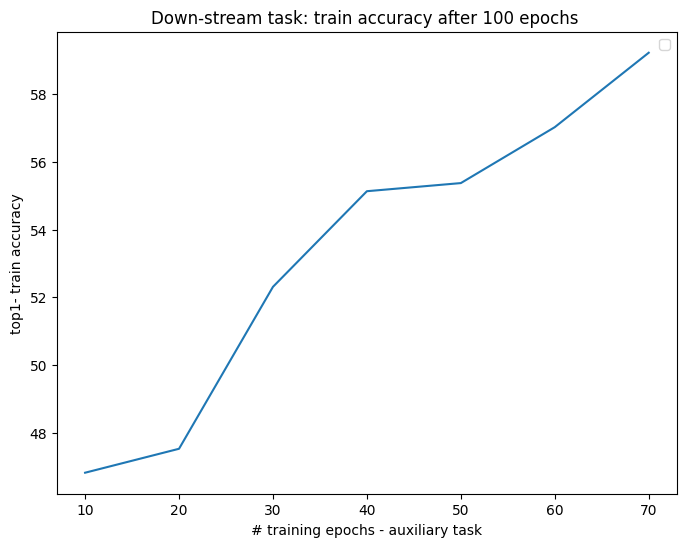

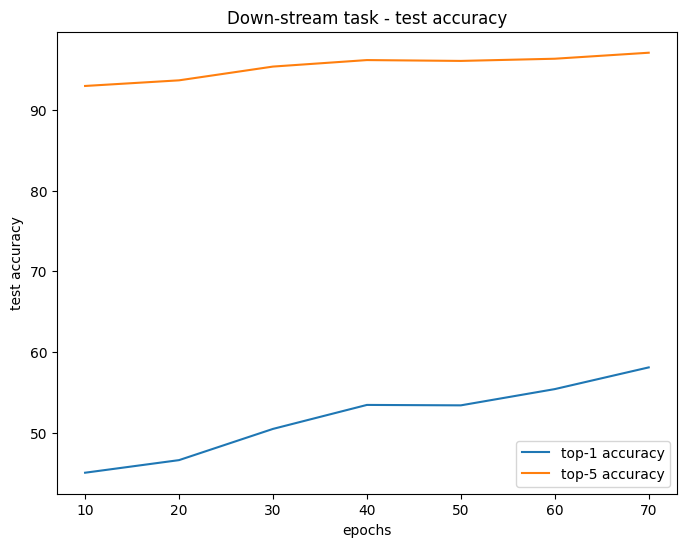

In [ ]:
#plot results
import matplotlib.pyplot as plt

# Plot train_results
plt.figure(figsize=(8, 6))

plt.plot(range(10, 80, 10),train_results[:, 0])
plt.title("Down-stream task: train accuracy after 100 epochs ")
plt.xlabel('# training epochs - auxiliary task')
plt.ylabel('top1- train accuracy')
plt.legend()
plt.show()

# Plot test_results
plt.figure(figsize=(8, 6))
labels = ['top-1 accuracy', 'top-5 accuracy']
for i in range(test_results.shape[1]):
    plt.plot(range(10, 80, 10),test_results[:, i], label=labels[i])
plt.title('Down-stream task - test accuracy')
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.legend()
plt.show()


# Step 0: Analysis of data transformations

Files already downloaded and verified


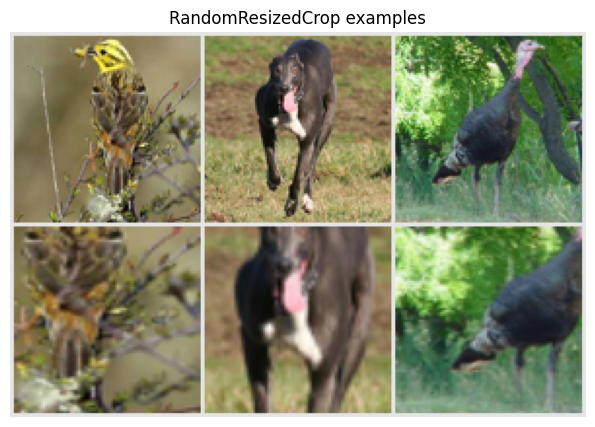

In [ ]:
# visualiser l'impact de chaque transformation sur quelques exemples
import matplotlib.pyplot as plt
## Torchvision
import torchvision
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets

# Define the function to load the dataset
images_fn = lambda: datasets.STL10("./datasets", split='train',  download=True)

# Load the dataset
dataset = images_fn()

# Define the transformation to convert images to tensors
to_tensor = transforms.ToTensor()

# Apply the transformation to each image in the dataset
tensor_dataset = torch.stack([to_tensor(img[0]) for img in dataset])

NUM_IMAGES = 3
images = tensor_dataset[:NUM_IMAGES]

# Apply transformations to each image separately
img_transformed = torch.stack([transforms.RandomResizedCrop(96)(img) for img in images])

imgs = torch.cat([images, img_transformed])
img_grid = torchvision.utils.make_grid(imgs, nrow=3, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('RandomResizedCrop examples')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()


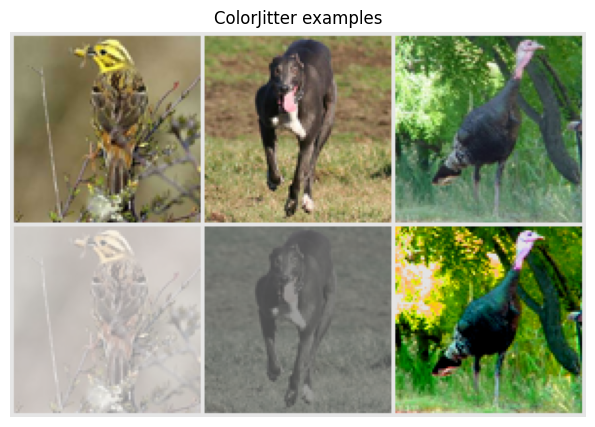

In [ ]:

NUM_IMAGES = 3
images = tensor_dataset[:NUM_IMAGES]

# Apply transformations to each image separately
img_transformed = torch.stack([transforms.RandomApply([transforms.ColorJitter(brightness=0.8,
                                                       contrast=0.8,
                                                       saturation=0.8,
                                                       hue=0.1)], p=0.8)(img) for img in images])


imgs = torch.cat([images, img_transformed])
img_grid = torchvision.utils.make_grid(imgs, nrow=3, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('ColorJitter examples')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()


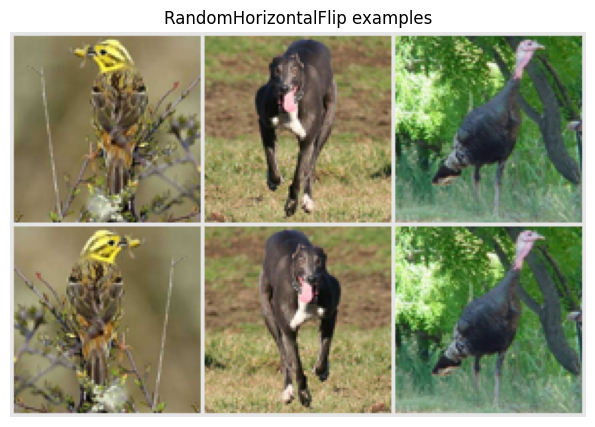

In [ ]:
NUM_IMAGES = 3
images = tensor_dataset[:NUM_IMAGES]

# Apply transformations to each image separately
img_transformed = torch.stack([transforms.RandomHorizontalFlip()(img) for img in images])


imgs = torch.cat([images, img_transformed])
img_grid = torchvision.utils.make_grid(imgs, nrow=3, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('RandomHorizontalFlip examples')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()


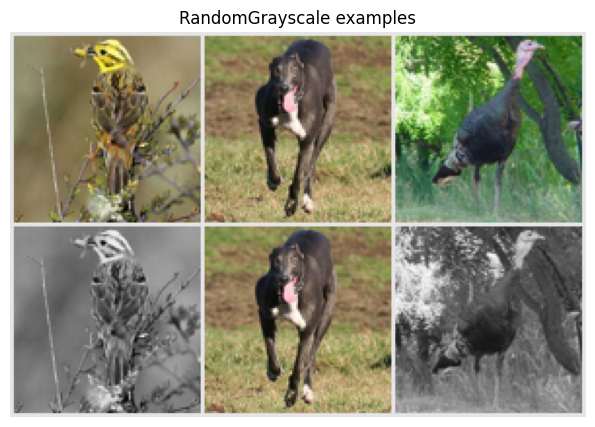

In [ ]:

NUM_IMAGES = 3
images = tensor_dataset[:NUM_IMAGES]


# Apply transformations to each image separately
img_transformed = torch.stack([transforms.RandomGrayscale(p=0.2)(img) for img in images])


imgs = torch.cat([images, img_transformed])
img_grid = torchvision.utils.make_grid(imgs, nrow=3, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('RandomGrayscale examples')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

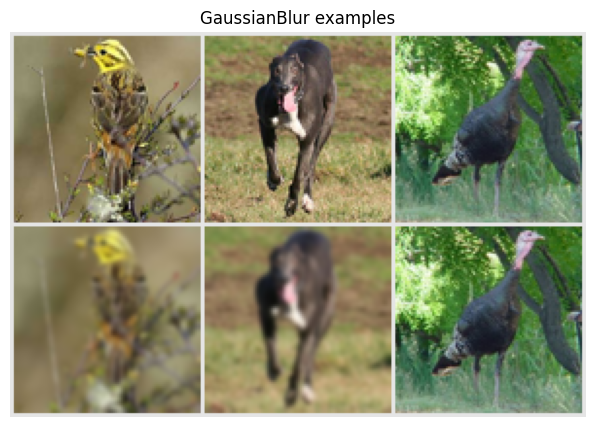

In [ ]:

NUM_IMAGES = 3
images = tensor_dataset[:NUM_IMAGES]


# Apply transformations to each image separately
img_transformed = torch.stack([transforms.GaussianBlur(kernel_size=9)(img) for img in images])


imgs = torch.cat([images, img_transformed])
img_grid = torchvision.utils.make_grid(imgs, nrow=3, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('GaussianBlur examples')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

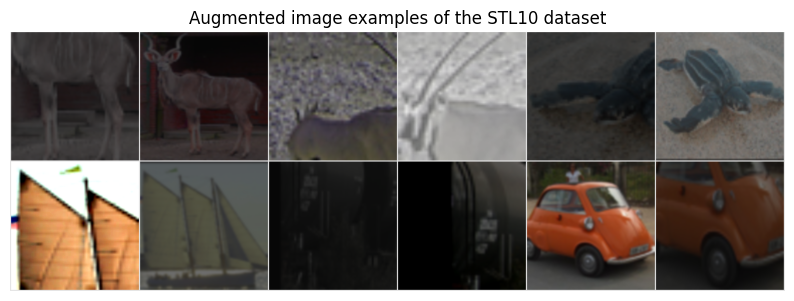

In [ ]:
# Visualiser quelques exemples de paires d'images transformées
import matplotlib.pyplot as plt
import torchvision
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in train_dataset[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()